In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib as mpl
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.convolution.kernels import CustomKernel

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [4]:
%matplotlib inline

In [5]:
plt.style.use('court.mplstyle')

try Monotone interpolants https://docs.scipy.org/doc/scipy/tutorial/interpolate/1D.html

In [6]:
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator

In [7]:
# https://dsp.stackexchange.com/questions/1676/savitzky-golay-
#smoothing-filter-for-not-equally-spaced-data

def non_uniform_savgol(x, y, window, polynom):
    """
    Applies a Savitzky-Golay filter to y with non-uniform spacing
    as defined in x

    This is based on https://dsp.stackexchange.com/questions/1676/
    savitzky-golay-smoothing-filter-for-not-equally-spaced-data
    The borders are interpolated like scipy.signal.savgol_filter would do

    Parameters
    ----------
    x : array_like
        List of floats representing the x values of the data
    y : array_like
        List of floats representing the y values. Must have same length
        as x
    window : int (odd)
        Window length of datapoints. Must be odd and smaller than x
    polynom : int
        The order of polynom used. Must be smaller than the window size

    Returns
    -------
    np.array of float
        The smoothed y values
    """
    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))     # Matrix
    tA = np.empty((polynom, window))    # Transposed matrix
    t = np.empty(window)                # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]

        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]

        # Multiply the two matrices
        tAA = np.matmul(tA, A)

        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)

        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)

        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]

    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]

    return y_smoothed

In [8]:
# BAAVSO = pd.read_csv('../data/RCB_LC_FORTESTING/R CRB_20231107_054548.csv')
# BAAVSO

AAVSO = pd.read_csv('../data/RCB_LC_FORTESTING/aavsodata_654aee1764b5f.txt')
AAVSO

/var/folders/5_/9nz8zb3j1nd7ngnmb4btgpjh0000gq/T/ipykernel_28029/3820215782.py:4: DtypeWarning: Columns (1,7,8,9,12,14,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  AAVSO = pd.read_csv('../data/RCB_LC_FORTESTING/aavsodata_654aee1764b5f.txt')


,JD,Magnitude,Uncertainty,HQuncertainty,Band,Observer Code,Comment Code(s),Comp Star 1,Comp Star 2,Charts,...,Cmag,Kmag,HJD,Star Name,Observer Affiliation,Measurement Method,Grouping Method,ADS Reference,Digitizer,Credit
0,2.372845e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
1,2.372848e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
2,2.373158e+06,6.28,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
3,2.376818e+06,<7.8,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
4,2.376841e+06,8.18,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327815,2.460252e+06,6.5,NaN,NaN,Vis.,PYG,U,V=E,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN
327816,2.460254e+06,6.4,NaN,NaN,Vis.,JDAA,NaN,5.8,6.5,X28730MQ,...,NaN,NaN,NaN,R CRB,AAVSO,STD,NaN,NaN,NaN,NaN
327817,2.460254e+06,6.3,NaN,NaN,Vis.,PYG,U,E+2,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN
327818,2.460254e+06,6.1,NaN,NaN,Vis.,CLQ,NaN,5.6,6.4,X20620ANN,...,NaN,NaN,NaN,R CrB,AAVSO,STD,NaN,NaN,NaN,NaN


In [170]:
vband = AAVSO[AAVSO['Band']=='Vis.'].reset_index(drop=True)
vband

,JD,Magnitude,Uncertainty,HQuncertainty,Band,Observer Code,Comment Code(s),Comp Star 1,Comp Star 2,Charts,...,Cmag,Kmag,HJD,Star Name,Observer Affiliation,Measurement Method,Grouping Method,ADS Reference,Digitizer,Credit
0,2.372845e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
1,2.372848e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
2,2.373158e+06,6.28,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
3,2.376818e+06,<7.8,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
4,2.376841e+06,8.18,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306466,2.460252e+06,6.5,NaN,NaN,Vis.,PYG,U,V=E,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN
306467,2.460254e+06,6.4,NaN,NaN,Vis.,JDAA,NaN,5.8,6.5,X28730MQ,...,NaN,NaN,NaN,R CRB,AAVSO,STD,NaN,NaN,NaN,NaN
306468,2.460254e+06,6.3,NaN,NaN,Vis.,PYG,U,E+2,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN
306469,2.460254e+06,6.1,NaN,NaN,Vis.,CLQ,NaN,5.6,6.4,X20620ANN,...,NaN,NaN,NaN,R CrB,AAVSO,STD,NaN,NaN,NaN,NaN


In [171]:
faint_mask = []
for i in range(0,len(vband)):
    
    if str(vband['Magnitude'].iloc[i])[0] == '<' or str(vband['Magnitude'].iloc[i])[0] == '>':
#         print()
        print(i,vband['Magnitude'].iloc[i],vband['Observer Code'].iloc[i])
        faint_mask.append(False)
    else:
#         print(i,vband['Magnitude'].iloc[i])
        faint_mask.append(True)
faint_mask = np.asarray(faint_mask)

# vband['Magnitude'][str(np.asarray(vband['Magnitude']))[0]=='<']

3 <7.8 PIGE
24 <7.8 PIGE
25 <7.8 PIGE
26 <7.8 PIGE
27 <7.8 PIGE
28 <7.8 PIGE
29 <7.8 PIGE
30 <7.8 PIGE
31 <7.8 PIGE
103 <8.0 AFW
104 <8.0 AFW
105 <8.0 AFW
106 <8.0 AFW
107 <8.0 AFW
108 <8.0 AFW
156 <6.2 AFW
181 <10.0 AFW
182 <10.0 AFW
183 <10.0 AFW
184 <10.0 AFW
298 <9.7 AFW
536 <9.3 AFW
577 <9.6 AFW
639 <9.8 AFW
1649 <11.0 MWK
1665 <8.4 RWX
1759 <6.6 PUL
1760 <6.6 PUL
2152 <5.6 MWK
2417 <13.8 VA
2436 <11.8 C
2443 <11.5 C
2482 <11.4 CEL
2661 <10.7 CEL
2787 <10.7 EA
2788 <9.8 SHM
2789 <9.5 O
2790 <13.0 CEL
2793 <10.7 JB
2800 <10.3 O
2801 <10.3 SHM
2805 <10.7 EA
2826 <10.3 SHM
2832 <10.3 JB
4864 <6.1 E
5503 <8.9 VGZ
5506 <10.6 O
5507 <9.2 VGZ
5511 <9.5 LY
5512 <9.0 VGZ
5513 <9.5 LY
5514 <11.4 MAC
5520 <12.2 L
5523 <11.8 PI
5524 <12.2 PIS
5525 <12.0 WHC
5527 <11.4 BUR
5532 <10.7 SHM
5533 <10.0 VGZ
5538 <12.2 BUR
5539 <10.7 CJJ
5543 <12.2 BUR
5546 <11.4 PI
5547 <10.7 SHM
5548 <10.7 V
5549 <10.7 SHM
5551 <13.1 BUR
5552 <12.6 CJJ
5554 <12.2 L
5556 <12.2 BUR
5557 <12.6 CJJ
5559 <9.0 VGZ
5560 

49573 <10.6 HQ
49575 <12.1 P
49576 <11.5 FE
49577 <10.5 RB
49579 <12.1 P
49580 <10.5 RB
49581 <12.0 FE
49582 <12.2 RB
49583 <13.1 LR
49584 <12.2 CEQ
49585 <10.6 HQ
49586 <12.1 P
49587 <12.2 L
49589 <11.5 HQ
49590 <9.8 DE
49594 <12.1 P
49595 <10.6 HQ
49596 <12.1 P
49597 <12.0 BJR
49599 <12.1 P
49600 <13.5 LR
49601 <12.5 LV
49603 <12.2 BU
49604 <11.5 CA
49606 <12.2 WB
49607 <12.2 RB
49609 <13.1 P
49611 <7.2 ELD
49615 <12.2 RB
49616 <11.5 HQ
49617 <12.2 P
49620 <12.0 BJR
49621 <10.0 SLT
49622 <11.5 HQ
49624 <13.1 SKE
49626 <11.5 HW
49627 <13.1 RB
49630 <11.5 HQ
49638 <13.1 CH
49639 <9.4 DE
49642 <11.5 HQ
49645 <12.2 PB
49648 <11.5 CA
49649 <12.2 P
49652 <12.0 BJR
49655 <11.5 HQ
49656 <12.2 P
49663 <11.5 HQ
49667 <11.5 HQ
49669 <11.5 HQ
49677 <9.5 CC
49679 <11.5 CA
49680 <11.5 HQ
49681 <10.3 CC
49682 <11.5 HQ
49685 <7.0 LJ
49687 <10.6 SLT
49690 <11.5 RB
49691 <11.5 HQ
49692 <7.0 LJ
49698 <10.6 DVM
49700 <10.6 HW
49701 <10.6 LKJ
49704 <10.5 RB
49708 <10.5 RB
49715 <10.5 RB
49722 <9.5 SLT
49

86530 <6.28 LRJ
86587 <7.63 HPM
86588 <8.0 MIW
86623 <8.6 HRB
86625 <9.36 TLA
86637 <8.88 HRB
86638 <10.66 TLA
86639 <8.28 HPM
86647 <9.36 HRB
86648 <9.82 TLA
86652 <11.1 SSL
86663 <8.6 HRB
86665 <8.6 HPM
86667 <10.66 TLA
86675 <8.0 MIW
86684 <9.36 TLA
86690 <12.2 LRJ
86699 <9.49 HRB
86700 <10.66 TLA
86737 <9.36 HPM
86746 <9.36 HPM
86778 <11.36 LRJ
86791 <12.2 FJH
86796 <11.36 LRJ
86801 <9.49 HRB
86805 <10.66 TLA
86815 <12.63 LRJ
86835 <9.36 TLA
86838 <11.36 HRB
86840 <10.6 MIW
86853 <10.66 TLA
86854 <11.36 SMJC
86866 <12.2 LRJ
86873 <10.66 HOW
86878 <7.18 HPM
86887 <10.66 SMJC
86890 <12.63 LRJ
86905 <12.63 LRJ
86914 <11.1 HPM
86920 <11.1 HPM
86923 <10.66 TLA
86930 <12.2 SMJC
86932 <10.66 TLA
86949 <10.66 FRN
87092 <9.49 HRB
87133 <8.88 HRB
87276 <8.88 HRB
87327 <7.93 HPM
87702 <6.57 HRB
93939 <9.2 RNI
93956 <8.88 SPA
94006 <8.88 SPA
94060 <8.88 BRET
94065 <8.88 BRET
94081 <8.88 SPA
94090 <10.66 TLA
94114 <9.36 RNI
94121 <9.36 BRET
94124 <9.49 SPA
94163 <9.36 BRET
94175 <9.36 RNI
94195

267794 <6.5 LMF
268084 <6.5 LMF
268134 <6.5 LMF
268184 <6.4 LMF
268317 <7.0 SSU
268510 <6.0 SDAV
268545 <7.4 GFT
268641 <7.4 SKA
268732 <8.9 HUR
268736 <9.3 MEAJ
268777 <8.8 HUR
268792 <11.0 WPX
268821 <9.2 HUR
268861 <10.0 MEAJ
268862 <9.4 HUR
268878 <10.0 WPX
268921 <8.6 HUR
268950 <10.2 BXV
268977 <10.2 REP
268982 <11.9 MED
268983 <11.8 FOM
268990 <12.2 PPL
269023 <11.8 GAW
269058 <11.8 MED
269067 <10.6 LRD
269072 <10.3 SASC
269076 <12.2 KOS
269090 <10.2 PJJ
269105 <12.2 WBT
269110 <10.6 STF
269133 <12.2 KOS
269141 <9.0 LLZ
269145 <12.2 KOS
269168 <12.2 WBT
269173 <12.2 KOS
269194 <12.0 GDB
269198 <7.4 MEAJ
269199 <10.7 TLA
269202 <11.8 MED
269216 <12.2 KOS
269242 <12.2 HTN
269259 <9.3 FSR
269260 <10.3 SASC
269286 <12.2 KOS
269299 <12.2 KOS
269316 <10.2 SASC
269338 <12.2 KOS
269347 <12.6 GMQA
269348 <12.1 VED
269349 <9.5 KUC
269355 <11.5 MED
269361 <11.1 KMI
269373 <11.8 MED
269389 <12.6 GMQA
269393 <11.8 MED
269398 <12.2 KOS
269404 <11.8 GAW
269406 <11.0 MED
269411 <12.5 CR
269412 

271792 <13.5 GZN
271793 <13.8 TOO
271795 <14.2 SFS
271796 <13.4 MTH
271801 <14.3 EJO
271805 <13.8 TOO
271806 <13.5 BBJA
271807 <12.6 MTH
271811 <12.6 MTH
271813 <13.0 MPV
271815 <9.0 LLZ
271817 <13.1 KRS
271819 <12.6 MTH
271820 <13.8 GFT
271821 <14.0 KMA
271822 <11.8 PPL
271823 <13.1 BWX
271824 <12.6 ERB
271826 <13.5 GFT
271827 <13.1 SLH
271830 <13.1 MDP
271831 <13.0 MPV
271832 <14.0 ACO
271833 <14.2 MUY
271835 <14.3 EJO
271837 <13.8 PTT
271838 <11.5 MED
271839 <13.1 KRS
271842 <13.0 MPV
271843 <11.5 MED
271844 <12.2 MTH
271845 <13.8 SSU
271846 <10.0 SASC
271847 <14.2 HHU
271848 <11.9 MTH
271849 <13.7 GZN
271850 <13.5 GFT
271851 <11.5 MED
271853 <13.5 PTT
271854 <11.9 MTH
271856 <13.4 OJR
271857 <13.1 GFT
271858 <12.6 MTH
271859 <12.6 MTH
271860 <11.0 MED
271861 <12.6 MTH
271863 <11.5 MED
271865 <12.6 MTH
271866 <13.5 GZN
271867 <13.4 OJR
271868 <10.7 GMQA
271870 <13.5 PTT
271872 <13.8 TOO
271875 <14.2 BRJ
271877 <12.6 MTH
271878 <11.5 MED
271879 <13.8 PTT
271880 <12.2 GMQA
271882 <13.

273160 <13.4 PLP
273161 <14.3 FMR
273163 <13.4 BLQ
273164 <13.4 ADI
273165 <14.1 OJR
273166 <13.1 WUB
273167 <12.8 PHG
273168 <13.5 GZN
273169 <9.5 MEAJ
273170 <11.8 MED
273171 <10.2 FSU
273173 <12.8 MTH
273175 <14.3 ACO
273176 <14.5 ATI
273177 <14.5 ATI
273178 <13.4 BLQ
273179 <13.7 TPS
273180 <13.5 GZN
273181 <11.8 MED
273183 <12.2 MPS
273184 <12.8 MTH
273185 <14.5 ATI
273186 <14.5 ATI
273187 <13.4 BLQ
273188 <12.7 GMQA
273189 <14.1 OJR
273190 <9.5 ASW
273193 <11.8 MED
273194 <13.4 MTH
273195 <14.5 ATI
273196 <14.5 ATI
273197 <14.0 PPS
273199 <12.2 GMQA
273200 <13.4 BLQ
273202 <14.0 DAM
273203 <11.8 MED
273204 <13.8 BWX
273206 <13.4 MDP
273207 <12.8 MTH
273208 <13.4 BLQ
273209 <13.4 ATI
273210 <13.4 ATI
273212 <13.5 GZN
273213 <11.8 MED
273215 <13.5 BWX
273216 <11.9 BJQ
273217 <13.4 MTH
273218 <14.5 ATI
273219 <14.5 ATI
273220 <14.3 FMR
273221 <13.5 CJE
273222 <13.4 BLQ
273223 <13.4 OJR
273224 <14.1 PHG
273225 <13.5 GZN
273226 <11.8 MED
273228 <11.9 BJQ
273229 <13.4 MTH
273230 <13.5 

274788 <13.2 TPS
274791 <11.5 MED
274793 <9.5 ASW
274794 <11.9 GMQA
274795 <12.2 BLQ
274801 <12.2 GMQA
274802 <11.1 SYU
274803 <11.5 MED
274804 <9.5 MCDB
274808 <12.2 GMQA
274814 <13.2 KTZ
274817 <11.1 SYU
274819 <12.2 WWJ
274820 <12.2 BLQ
274823 <12.8 BLQ
274824 <12.2 BBI
274825 <11.1 SYU
274827 <12.2 GMQA
274831 <13.5 LCR
274840 <11.1 SYU
274841 <13.5 TPS
274844 <8.1 MEAJ
274847 <11.9 GMQA
274851 <12.8 PHG
274857 <12.8 KIS
274858 <8.4 SYU
274861 <11.0 MED
274867 <12.7 BPO
274868 <7.8 MEAJ
274872 <12.8 BBI
274873 <12.2 SYU
274874 <13.1 GZN
274875 <9.2 ASW
274876 <11.5 MED
274881 <13.1 GZN
274884 <12.2 MTH
274885 <7.8 MEAJ
274886 <13.1 GZN
274887 <12.2 GMQA
274888 <11.0 MED
274890 <9.5 MCDB
274895 <12.2 GMQA
274896 <13.1 GZN
274897 <9.5 ASW
274901 <11.9 SYU
274902 <13.1 GZN
274907 <12.8 BLQ
274909 <11.9 GMQA
274911 <12.8 BPO
274915 <12.2 MTH
274926 <12.2 MTH
274930 <11.1 SYU
274931 <8.0 BQ
274933 <9.5 ASW
274940 <12.8 GMQA
274946 <12.8 GMQA
274951 <12.8 BLQ
274957 <12.2 MTH
274963 <12.

279954 <8.6 ASW
279963 <12.7 BLQ
279966 <12.8 BLQ
279967 <12.7 BHS
279970 <9.5 FSR
279971 <12.2 BHS
279972 <12.8 BLQ
279973 <13.4 TOO
279974 <13.4 LTE
279975 <11.8 MED
279976 <11.5 MED
279980 <13.8 LCR
279981 <14.1 TOO
279982 <12.8 BLQ
279983 <13.4 SLH
279987 <14.1 TOO
279988 <10.5 MED
279990 <9.2 ASW
279991 <12.2 CKB
279992 <11.5 MED
279993 <14.1 BFO
279994 <14.1 TOO
279995 <11.5 MED
279997 <11.5 MED
279998 <14.1 TOO
279999 <11.8 MED
280000 <13.4 ATI
280003 <8.6 ASW
280006 <8.7 ASW
280007 <14.1 SLH
280008 <11.5 MED
280012 <14.1 TOO
280015 <11.5 MED
280016 <12.2 OCR
280017 <12.2 OCR
280020 <14.1 TOO
280021 <11.8 MED
280023 <11.5 MED
280025 <13.4 CKB
280027 <11.5 MED
280029 <11.1 BNBA
280031 <13.4 CKB
280032 <10.6 BNBA
280033 <11.5 MED
280035 <12.8 BLQ
280036 <14.1 BFO
280037 <11.8 MED
280038 <11.0 BNBA
280039 <13.8 LCR
280042 <11.8 MED
280043 <13.9 VNL
280044 <11.0 BNBA
280045 <13.4 BLQ
280046 <13.8 LCR
280047 <13.0 TPS
280049 <11.8 MED
280050 <13.4 ATI
280051 <14.1 TOO
280053 <13.4 AT

285238 <11.5 MED
285242 <11.5 MED
285243 <8.9 ASW
285244 <10.0 CALC
285245 <13.4 BLQ
285246 <13.4 PRCA
285251 <11.8 MED
285255 <10.7 DXAA
285256 <12.8 PRCA
285259 <13.4 MDP
285260 <11.8 MED
285265 <13.4 VTY
285267 <12.2 VED
285270 <13.4 BLQ
285271 <11.8 MED
285272 <9.5 ASW
285273 <14.3 PTT
285274 <13.4 PRCA
285280 <13.4 SEDB
285281 <12.5 VED
285282 <13.4 BLQ
285287 <12.0 MED
285288 <13.4 KIS
285291 <13.8 LCR
285292 <12.2 JGE
285294 <13.4 HSP
285296 <11.8 MED
285297 <14.3 PTT
285299 <13.4 PRCA
285305 <12.8 BLQ
285307 <11.8 MED
285308 <12.5 VED
285309 <13.8 PTT
285311 <9.5 ASW
285312 <10.0 CALC
285318 <12.8 BLQ
285319 <11.8 MED
285320 <13.8 PTT
285323 <13.4 PRCA
285328 <11.5 RLJA
285331 <13.4 MDP
285334 <11.8 MED
285340 <12.8 BLQ
285348 <11.1 GMD
285351 <11.5 MED
285352 <12.8 BLQ
285355 <12.8 PRCA
285357 <10.2 KPC
285358 <13.4 MDP
285360 <10.0 KJAF
285361 <12.8 LCR
285362 <13.4 SEDB
285365 <11.1 DXAA
285366 <12.2 REP
285367 <11.5 MED
285368 <12.2 REP
285370 <12.8 VTY
285372 <13.4 SYU
285

In [172]:
## mask out the people who only contribute one observation
observer_code = np.unique(vband['Observer Code'])
print(len(observer_code))

bad_observers = []
for observer in observer_code:
#     print(observer)
    data_from_observer = vband[vband['Observer Code']==observer]
    if len(data_from_observer)<20:
        bad_observers.append(observer)
#     print(len(data_from_observer))
print(len(bad_observers))

3076
1785


In [173]:
observer_mask = []
for i in range(0,len(vband)):
    if vband['Observer Code'][i] in bad_observers:
        observer_mask.append(False)
    else:
        observer_mask.append(True)
observer_mask = np.asarray(observer_mask)
observer_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [174]:
aavso_mask = observer_mask & faint_mask

In [175]:
vband = vband[aavso_mask].reset_index(drop=True)
vband = vband.astype({'Magnitude': np.float64})
vband

,JD,Magnitude,Uncertainty,HQuncertainty,Band,Observer Code,Comment Code(s),Comp Star 1,Comp Star 2,Charts,...,Cmag,Kmag,HJD,Star Name,Observer Affiliation,Measurement Method,Grouping Method,ADS Reference,Digitizer,Credit
0,2.372845e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
1,2.372848e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
2,2.373158e+06,6.28,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
3,2.376841e+06,8.18,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
4,2.376844e+06,8.08,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289788,2.460252e+06,6.50,NaN,NaN,Vis.,PYG,U,V=E,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN
289789,2.460254e+06,6.40,NaN,NaN,Vis.,JDAA,NaN,5.8,6.5,X28730MQ,...,NaN,NaN,NaN,R CRB,AAVSO,STD,NaN,NaN,NaN,NaN
289790,2.460254e+06,6.30,NaN,NaN,Vis.,PYG,U,E+2,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN
289791,2.460254e+06,6.10,NaN,NaN,Vis.,CLQ,NaN,5.6,6.4,X20620ANN,...,NaN,NaN,NaN,R CrB,AAVSO,STD,NaN,NaN,NaN,NaN


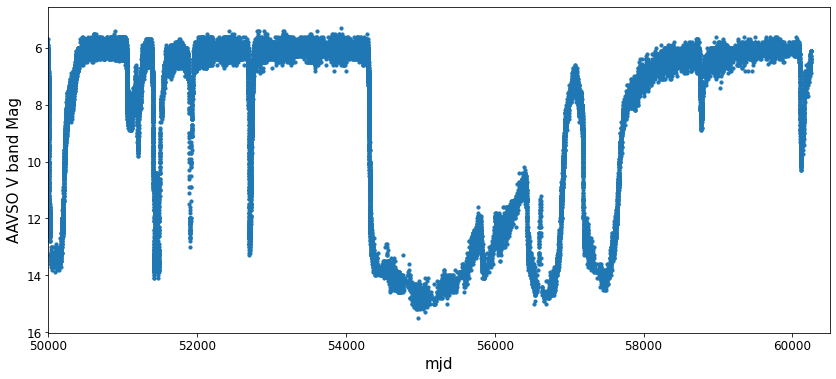

In [176]:
plt.figure(figsize=(14,6))

plt.scatter(vband['JD']-2400000.5,vband['Magnitude'],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd')
plt.ylabel('AAVSO V band Mag')
plt.xlim(50000,60500)
# plt.xlim(55000,60500)
# plt.xlim(left=20000)
plt.show()

In [177]:
# pretend this dataframe is something else
oband = vband
oband.rename(columns={"JD": "mjd", "Magnitude": "m"},inplace=True)
oband

,mjd,m,Uncertainty,HQuncertainty,Band,Observer Code,Comment Code(s),Comp Star 1,Comp Star 2,Charts,...,Cmag,Kmag,HJD,Star Name,Observer Affiliation,Measurement Method,Grouping Method,ADS Reference,Digitizer,Credit
0,2.372845e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
1,2.372848e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
2,2.373158e+06,6.28,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
3,2.376841e+06,8.18,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
4,2.376844e+06,8.08,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289788,2.460252e+06,6.50,NaN,NaN,Vis.,PYG,U,V=E,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN
289789,2.460254e+06,6.40,NaN,NaN,Vis.,JDAA,NaN,5.8,6.5,X28730MQ,...,NaN,NaN,NaN,R CRB,AAVSO,STD,NaN,NaN,NaN,NaN
289790,2.460254e+06,6.30,NaN,NaN,Vis.,PYG,U,E+2,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN
289791,2.460254e+06,6.10,NaN,NaN,Vis.,CLQ,NaN,5.6,6.4,X20620ANN,...,NaN,NaN,NaN,R CrB,AAVSO,STD,NaN,NaN,NaN,NaN


In [178]:
oband = oband.sort_values(by=['mjd'],axis=0,ascending=True,ignore_index=True)
oband = oband.drop_duplicates(subset=['mjd'],ignore_index=True) 
    # this keeps the first entry, I'd love if it took an average
oband

,mjd,m,Uncertainty,HQuncertainty,Band,Observer Code,Comment Code(s),Comp Star 1,Comp Star 2,Charts,...,Cmag,Kmag,HJD,Star Name,Observer Affiliation,Measurement Method,Grouping Method,ADS Reference,Digitizer,Credit
0,2.372845e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
1,2.372848e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
2,2.373158e+06,6.28,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
3,2.376841e+06,8.18,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
4,2.376844e+06,8.08,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210179,2.460252e+06,6.50,NaN,NaN,Vis.,PYG,U,V=E,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN
210180,2.460254e+06,6.40,NaN,NaN,Vis.,JDAA,NaN,5.8,6.5,X28730MQ,...,NaN,NaN,NaN,R CRB,AAVSO,STD,NaN,NaN,NaN,NaN
210181,2.460254e+06,6.30,NaN,NaN,Vis.,PYG,U,E+2,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN
210182,2.460254e+06,6.10,NaN,NaN,Vis.,CLQ,NaN,5.6,6.4,X20620ANN,...,NaN,NaN,NaN,R CrB,AAVSO,STD,NaN,NaN,NaN,NaN


In [13]:
atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_WISEJ194218.38-203247.5_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_AOHer_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-14_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-16_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-19_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_ASAS-RCB-21_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_ASAS-RCB-7_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_EROS2-CG-RCB-10_ATLAS.csv')
atlas

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.404176,12.700,0.002,30188.0,71.0,o,0,132.78,295.57658,-20.54653,618.20,1538.11,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
2,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
3,57228.429475,12.729,0.002,29403.0,71.0,o,0,65.54,295.57658,-20.54653,10151.01,8809.96,3.75,3.33,-83.2,-0.451,18.85,20.15,02a57228o0218o
4,57228.451599,12.728,0.002,29433.0,73.0,o,0,124.82,295.57658,-20.54653,2602.82,553.77,3.88,3.61,-41.5,-0.453,18.96,20.34,02a57228o0243o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4611,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o
4612,60085.289962,15.891,0.012,1597.0,20.0,o,0,7.68,295.57660,-20.54654,3483.49,4412.50,2.05,1.87,84.7,-0.423,19.29,20.65,04a60085o0743o
4613,60093.044580,18.811,0.103,108.0,11.0,c,0,1.20,295.57660,-20.54654,9278.83,6021.04,2.94,2.75,-33.6,-0.361,19.45,21.42,03a60093o0736c
4614,60093.047335,18.616,0.090,130.0,12.0,c,0,1.13,295.57660,-20.54654,9261.36,5982.77,2.91,2.67,-25.9,-0.358,19.48,21.42,03a60093o0742c


In [14]:
oband = atlas[atlas['f']=='o']
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.404176,12.700,0.002,30188.0,71.0,o,0,132.78,295.57658,-20.54653,618.20,1538.11,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
2,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
3,57228.429475,12.729,0.002,29403.0,71.0,o,0,65.54,295.57658,-20.54653,10151.01,8809.96,3.75,3.33,-83.2,-0.451,18.85,20.15,02a57228o0218o
4,57228.451599,12.728,0.002,29433.0,73.0,o,0,124.82,295.57658,-20.54653,2602.82,553.77,3.88,3.61,-41.5,-0.453,18.96,20.34,02a57228o0243o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4604,60079.361159,14.678,0.007,4884.0,33.0,o,0,32.80,295.57660,-20.54654,7076.95,2279.83,2.18,1.95,-19.6,-0.419,19.20,20.49,04a60079o0524o
4605,60079.384530,15.696,0.079,1912.0,150.0,o,0,0.98,295.57660,-20.54654,3581.78,8256.05,2.52,1.91,-79.3,-0.404,16.73,18.41,04a60079o0571o
4610,60085.284556,15.898,0.013,1588.0,21.0,o,0,5.27,295.57660,-20.54654,3442.06,4374.29,2.11,1.93,81.0,-0.416,19.29,20.60,04a60085o0731o
4611,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o


In [15]:
oband = oband.sort_values(by=['mjd'],axis=0,ascending=True,ignore_index=True)
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.393173,12.691,0.003,30460.0,76.0,o,0,65.80,295.57660,-20.54654,10453.99,1565.49,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
2,57228.404176,12.700,0.002,30194.0,71.0,o,0,130.24,295.57660,-20.54654,618.23,1538.13,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
3,57228.404176,12.700,0.002,30188.0,71.0,o,0,132.78,295.57658,-20.54653,618.20,1538.11,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
4,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301,60082.314898,15.257,0.009,2865.0,25.0,o,0,16.20,295.57658,-20.54653,5448.88,10403.51,2.60,1.82,-79.8,-0.413,19.23,20.51,04a60082o0770o
3302,60082.331080,15.234,0.010,2928.0,28.0,o,0,10.14,295.57658,-20.54653,8924.63,280.64,2.70,2.30,-31.4,-0.397,19.13,20.46,04a60082o0804o
3303,60085.284556,15.898,0.013,1588.0,21.0,o,0,5.27,295.57660,-20.54654,3442.06,4374.29,2.11,1.93,81.0,-0.416,19.29,20.60,04a60085o0731o
3304,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o


In [16]:
oband = oband.drop_duplicates(subset=['mjd'],ignore_index=True) 
    # this keeps the first entry, I'd love if it took an average
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.404176,12.700,0.002,30194.0,71.0,o,0,130.24,295.57660,-20.54654,618.23,1538.13,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
2,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
3,57228.429475,12.729,0.002,29403.0,71.0,o,0,65.54,295.57658,-20.54653,10151.01,8809.96,3.75,3.33,-83.2,-0.451,18.85,20.15,02a57228o0218o
4,57228.451599,12.727,0.002,29461.0,73.0,o,0,121.64,295.57660,-20.54654,2602.78,553.75,3.88,3.61,-41.5,-0.453,18.96,20.34,02a57228o0243o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788,60082.314898,15.257,0.009,2865.0,25.0,o,0,16.20,295.57658,-20.54653,5448.88,10403.51,2.60,1.82,-79.8,-0.413,19.23,20.51,04a60082o0770o
1789,60082.331080,15.234,0.010,2928.0,28.0,o,0,10.14,295.57658,-20.54653,8924.63,280.64,2.70,2.30,-31.4,-0.397,19.13,20.46,04a60082o0804o
1790,60085.284556,15.898,0.013,1588.0,21.0,o,0,5.27,295.57660,-20.54654,3442.06,4374.29,2.11,1.93,81.0,-0.416,19.29,20.60,04a60085o0731o
1791,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o


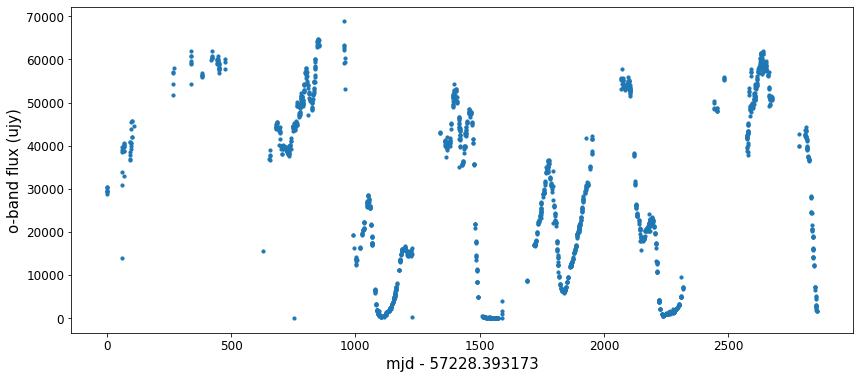

In [17]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['ujy'],s=10)#/(80000),s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band flux (ujy)')
# plt.ylim(-100,1000)
# plt.ylim(0.6,1.2)
# plt.xlim(1000,2000)
plt.show()

In [18]:
########################

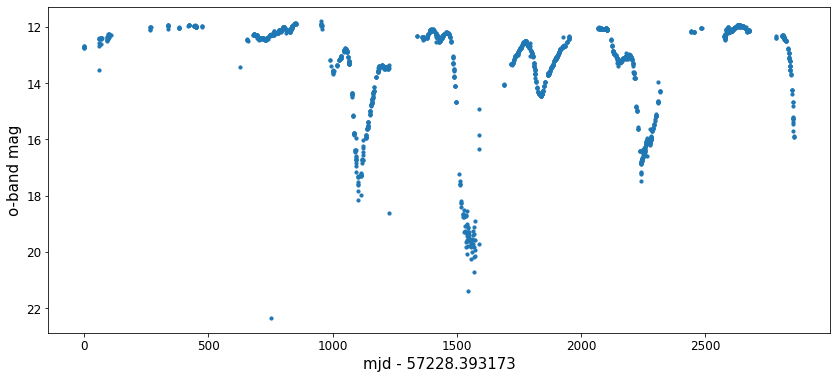

In [19]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10)#/(80000),s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band mag')
# plt.ylim(top=1.2)
# plt.ylim(0.6,1.2)
# plt.xlim(1000,2000)
plt.show()

In [20]:
# median_filtered = sp.signal.medfilt(oband['m'],kernel_size=5)

In [21]:
# plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered,s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('median filtered o-band magnitude')
# plt.show()

In [16]:
### will fail if duplicate data points
savgol_filtered = non_uniform_savgol(np.asarray(oband['mjd']-oband['mjd'][0]),
                                     np.asarray(oband['m']),
                                   window=7, polynom=1)

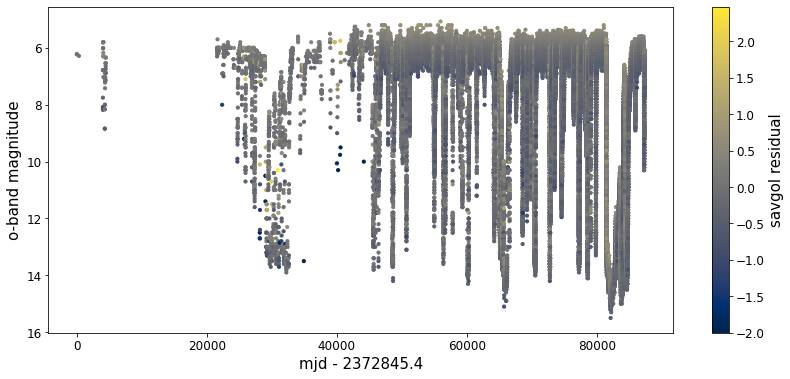

In [17]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10,
            c=savgol_filtered-oband['m'],cmap='cividis')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.colorbar(label='savgol residual')
# plt.clim(vmax=-1)
plt.clim(vmin=-2)
plt.show()

0.16338100181411488


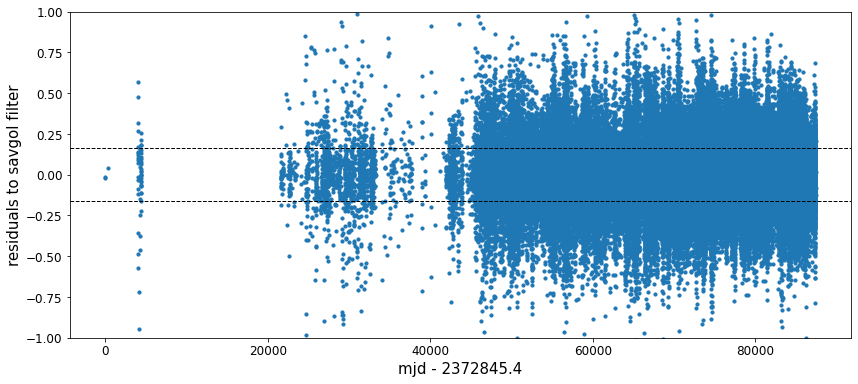

In [18]:
deviation = np.std(savgol_filtered-oband['m'])
print(deviation)

plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],savgol_filtered-oband['m'],s=10)
plt.axhline(deviation,color='k',linestyle='--')
plt.axhline(-deviation,color='k',linestyle='--')
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('residuals to savgol filter')
plt.ylim(-1,1)
plt.show()

In [19]:
# plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10,
#             c=median_filtered-oband['m'],cmap='cividis')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('o-band magnitude')
# plt.colorbar(label='median residual')
# # plt.clim(vmax=-1)
# plt.clim(vmin=-2)
# plt.show()

In [20]:
# deviation = np.std((median_filtered-oband['m']))
# print(deviation)

# plt.figure(figsize=(14,6))
# # plt.axvline(oband['mjd'][1000]-oband['mjd'][0])
# plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered-oband['m'],s=10)
# plt.axhline(deviation,color='k',linestyle='--')
# plt.axhline(-deviation,color='k',linestyle='--')
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('residuals to median filter')
# plt.ylim(-1,1)
# plt.show()

In [21]:
mask = np.where(np.abs(savgol_filtered-oband['m'])<deviation,True,False)
# mask

# mask = np.where(np.abs(median_filtered-oband['m'])<0.25,True,False)
# mask

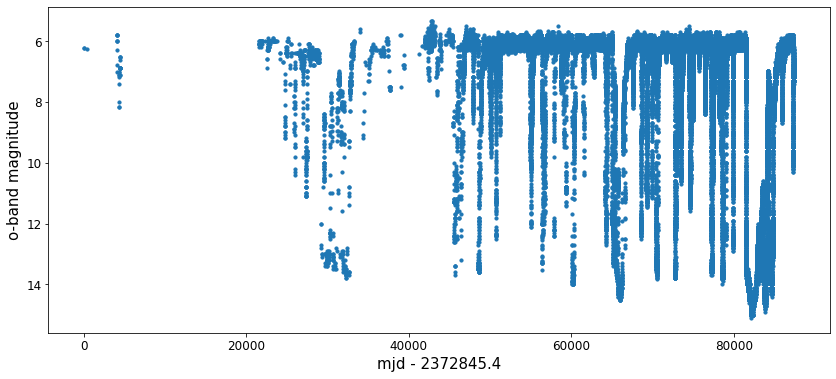

In [22]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd'][mask]-oband['mjd'][0],oband['m'][mask],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.show()

In [23]:
# median_filtered_oband = oband.iloc[mask]
# median_filtered_oband.reset_index(drop=True,inplace=True)
# median_filtered_oband

savgol_filtered_oband = oband.iloc[mask]
savgol_filtered_oband.reset_index(drop=True,inplace=True)
savgol_filtered_oband

# savgol_filtered_oband = oband
# savgol_filtered_oband.reset_index(drop=True,inplace=True)
# savgol_filtered_oband

,mjd,m,Uncertainty,HQuncertainty,Band,Observer Code,Comment Code(s),Comp Star 1,Comp Star 2,Charts,...,Cmag,Kmag,HJD,Star Name,Observer Affiliation,Measurement Method,Grouping Method,ADS Reference,Digitizer,Credit
0,2.372845e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
1,2.372848e+06,6.22,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
2,2.373158e+06,6.28,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
3,2.376864e+06,6.78,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
4,2.376875e+06,6.01,NaN,NaN,Vis.,PIGE,K,NaN,NaN,NaN,...,NaN,NaN,NaN,R CRB,NaN,STD,NaN,NaN,SCK,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161563,2.460251e+06,6.30,NaN,NaN,Vis.,MSEE,B,7.4,8.1,X28825BR,...,NaN,NaN,NaN,R CrB,AAVSO,STD,NaN,NaN,NaN,NaN
161564,2.460252e+06,6.50,NaN,NaN,Vis.,PYG,U,V=E,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN
161565,2.460254e+06,6.40,NaN,NaN,Vis.,JDAA,NaN,5.8,6.5,X28730MQ,...,NaN,NaN,NaN,R CRB,AAVSO,STD,NaN,NaN,NaN,NaN
161566,2.460254e+06,6.30,NaN,NaN,Vis.,PYG,U,E+2,NaN,041.04,...,NaN,NaN,NaN,R CRB,BAA-VSS,STD,NaN,NaN,NaN,NaN


In [24]:
iter_savgol_filtered = non_uniform_savgol(np.asarray(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0]),
                                     np.asarray(savgol_filtered_oband['m']),
                                   window=31, polynom=1)

In [25]:
# iter_savgol_filtered = savgol_filtered_oband['m']

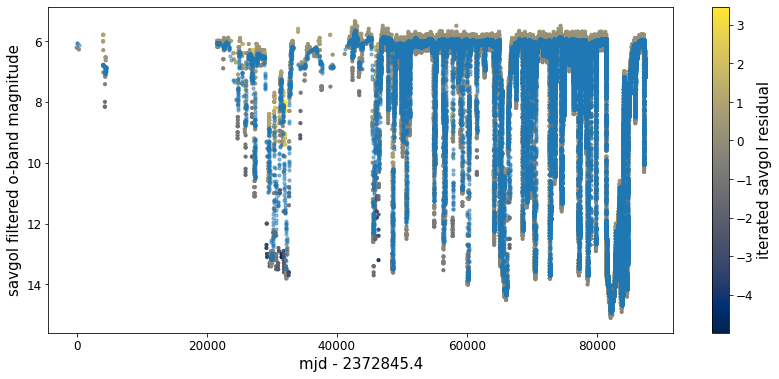

In [26]:
plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'],s=10,
            c=iter_savgol_filtered-savgol_filtered_oband['m'],cmap='cividis')
plt.colorbar(label='iterated savgol residual')
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],iter_savgol_filtered,s=10,alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='iterated savgol residual')
# plt.clim(vmax=-1)
# plt.clim(vmin=-2)
plt.show()

In [27]:
# local_std/2

In [28]:
# I think we can use that ATLAS saturates at around 11 mag # r ~ 12.5
# and limiting mag is ~20
local_std = np.std((iter_savgol_filtered-savgol_filtered_oband['m']))
saturation_limit = 0#12
saturation_mask = []
halfwidth=5
for i in range(0,len(iter_savgol_filtered)):
    if i > len(iter_savgol_filtered)-halfwidth:
        saturation_mask.append(True)
    elif i < halfwidth:
        saturation_mask.append(True)
    else:
        variation_window = np.max(np.abs(iter_savgol_filtered[i-halfwidth:i+halfwidth]-savgol_filtered_oband['m'][i-halfwidth:i+halfwidth]))
        if variation_window > 0.1 and np.mean(savgol_filtered_oband['m'][i-halfwidth:i+halfwidth])<saturation_limit:
    #         print('mask me')
            saturation_mask.append(False)
        else:
            saturation_mask.append(True)
# saturation_mask = np.where(np.abs(iter_savgol_filtered-savgol_filtered_oband['m'])<0.25,True,False)
# saturation_mask

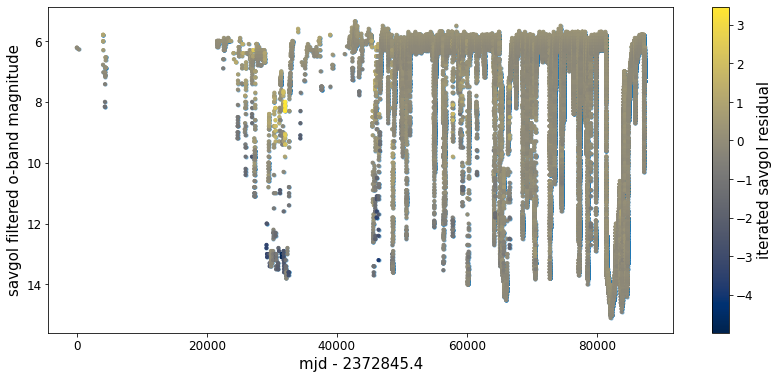

In [29]:
# saturation_replace = np.full(len(saturation_mask),11)

plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'],s=10,alpha=0.5)
plt.scatter(savgol_filtered_oband['mjd'][saturation_mask]-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'][saturation_mask],s=10,
            c=iter_savgol_filtered[saturation_mask]-savgol_filtered_oband['m'][saturation_mask],cmap='cividis')
# plt.scatter(savgol_filtered_oband['mjd'][np.invert(saturation_mask)]-savgol_filtered_oband['mjd'][0],
#            saturation_replace[np.invert(saturation_mask)],color='darkgrey')
plt.colorbar(label='iterated savgol residual')
# plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],iter_savgol_filtered,s=10,alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='iterated savgol residual')
# plt.clim(vmax=-1)
# plt.clim(vmin=-2)
plt.show()

In [30]:
# deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
# print(deviation)

# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered-savgol_filtered_oband['m'],s=10)
# plt.axhline(deviation,color='k',linestyle='--')
# plt.axhline(-deviation,color='k',linestyle='--')
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('residuals to savgol filter')
# # plt.ylim(-1,1)
# plt.show()

In [31]:
# mjd_scale = savgol_filtered_oband['mjd'][0]

# # median_filtered_oband['mjd']-mjd_scale,savgol_filtered
# time = savgol_filtered_oband['mjd']-mjd_scale

# # stddev_arr = []
# # saturation_mask = [False,False,False,False,False]
# deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
# # print(deviation)

# ### find the gaps in the data
# time_diff = np.diff(time)
# time_diff = np.append(time_diff,0)

# gap_mask = []#[False,False]
# for i in range(0,len(time)):
#     if time_diff[i] > 50:
#         gap_mask.append(True)
# #     elif (gap_mask[i-1] == True and gap_mask[i-2] == False):
# #         gap_mask.append(True)
#     else:
#         gap_mask.append(False)
        
# noise_mask = np.full(len(time),False)
# for i in range(0,len(time[gap_mask])):
#     if i == 0:
#         window = time<=time[time[gap_mask].index[i]]
# #         print(window)
#     elif i == len(time[gap_mask])-1:
#         window = time>=time[time[gap_mask].index[i]]
# #         print(window)
#     else:
#         window = np.logical_and(time>=time[time[gap_mask].index[i]],time<=time[time[gap_mask].index[i+1]])
# #     print(np.std(iter_savgol_filtered[window]-np.asarray(savgol_filtered_oband['m'])[window]))
# #     print(np.mean(np.asarray(savgol_filtered_oband['m'])[window])-np.min(savgol_filtered_oband['m']))
# #     print(np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(savgol_filtered_oband['m']))
#     if (np.std(iter_savgol_filtered[window]-np.asarray(savgol_filtered_oband['m'])[window]) > deviation 
#         and len(savgol_filtered_oband['m'][window]) > 50 and 
#         (np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(np.asarray(savgol_filtered_oband['m'])[window])) < 2.5
#        and (np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(savgol_filtered_oband['m'])) < 3.0):
#         print(len(savgol_filtered_oband['m'][window]))
#         print(np.max(np.asarray(savgol_filtered_oband['m'])[window])-np.min(np.asarray(savgol_filtered_oband['m'])[window]))
# #         print(i,'mask me')
#         noise_mask[window] = True
# #     print('------')
# noise_mask

In [32]:
# deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
# print(deviation)

# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered-savgol_filtered_oband['m'],s=10)
# # plt.scatter(savgol_filtered_oband['mjd'][saturation_mask]-savgol_filtered_oband['mjd'][0],
# #             iter_savgol_filtered[saturation_mask]-savgol_filtered_oband['m'][saturation_mask],s=10)
# plt.scatter(savgol_filtered_oband['mjd'][noise_mask]-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered[noise_mask]-savgol_filtered_oband['m'][noise_mask],s=10)
# plt.scatter(savgol_filtered_oband['mjd'][gap_mask]-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered[gap_mask]-savgol_filtered_oband['m'][gap_mask],s=30)

# plt.axhline(deviation,color='k',linestyle='--')
# plt.axhline(-deviation,color='k',linestyle='--')
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('residuals to savgol filter')
# plt.ylim(-1,1)
# plt.show()

In [33]:
# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'],s=10,
#             c=iter_savgol_filtered-savgol_filtered_oband['m'],cmap='cividis')
# plt.scatter(savgol_filtered_oband['mjd'][noise_mask]-savgol_filtered_oband['mjd'][0],
#             savgol_filtered_oband['m'][noise_mask],s=10,color='tab:red')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='iterated savgol residual')
# # plt.clim(vmax=-1)
# plt.clim(vmin=-2)
# plt.show()

In [34]:
# edge_detect = sp.ndimage.convolve(oband['m'][mask], CustomKernel([1.0, 0.0, -1.0]))
# edge_detect = sp.ndimage.convolve(savgol_filtered_oband['m'], [1.0, 0.0, -1.0])

In [35]:
# mjd_scale = savgol_filtered_oband['mjd'][0]


# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,edge_detect,s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('edge detection')
# plt.ylim(-1,1)
# plt.show()

In [36]:
# plt.figure(figsize=(14,6))
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,
#             c=edge_detect,cmap='bwr')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-1,1)
# plt.show()

In [37]:
# ###### TAKE THIS OUT IF YOU DON'T WANT TO MASK THE SATURATION #######
# savgol_filtered_oband = savgol_filtered_oband.iloc[saturation_mask]
# savgol_filtered_oband.reset_index(drop=True,inplace=True)
# iter_savgol_filtered = savgol_filtered_oband['m']
# savgol_filtered_oband

In [38]:
mjd_scale = savgol_filtered_oband['mjd'][0]

# smoothed_flux = convolve(median_filtered_oband['m'], Gaussian1DKernel(20),boundary='extend')

# interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(iter_savgol_filtered),
#                                                  kind='cubic')
interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
                                                 np.asarray(iter_savgol_filtered),
                                                 kind='linear')
# interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(savgol_filtered_oband['m']),
#                                                  kind='linear')

### attempting monotone interpolants ###
# interpolation_function = Akima1DInterpolator(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(iter_savgol_filtered)) # this one is bad
# interpolation_function = PchipInterpolator(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(iter_savgol_filtered)) # this one is better
# interpolation_function = PchipInterpolator(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(savgol_filtered_oband['m'])) # this one is better


## what time resolution? I don't want to lose any of the real data if possible
real_resolution = np.median(np.diff(savgol_filtered_oband['mjd']))
len_data = np.max(savgol_filtered_oband['mjd']-mjd_scale)
resample_time = np.linspace(0,len_data,int(len_data))#int(len_data/(real_resolution/10000)))
## currently resampling at a resolution of 1 day
resample_flux = interpolation_function(resample_time)

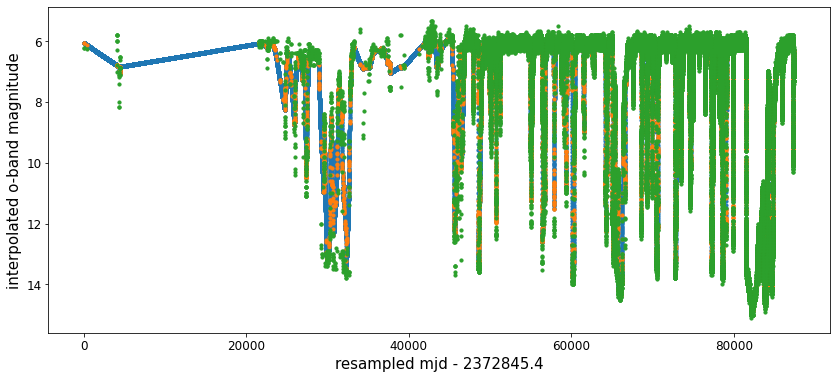

In [39]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10)
plt.scatter(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),np.asarray(iter_savgol_filtered),s=10)
plt.scatter(np.asarray(savgol_filtered_oband['mjd']-mjd_scale),np.asarray(savgol_filtered_oband['m']),s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
# plt.ylim(20.5,11)
# plt.ylim(14,11)
# plt.xlim(1000,1200)
plt.show()

In [40]:
new_edge_detect = sp.ndimage.convolve(resample_flux, [1.0, 0.0, -1.0])

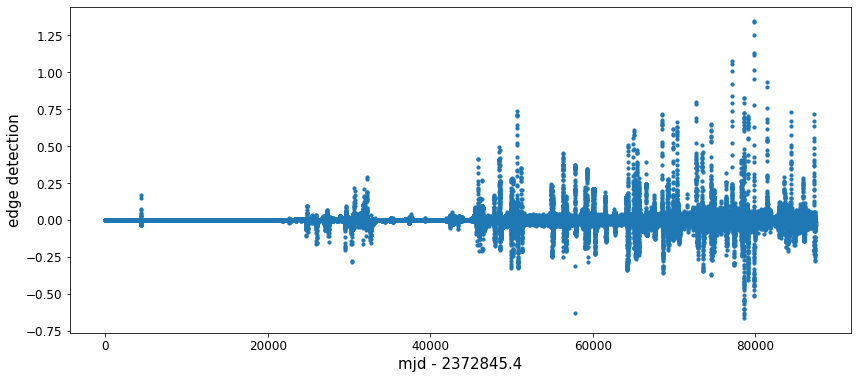

In [41]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,new_edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('edge detection')
# plt.ylim(-1,1)
plt.show()

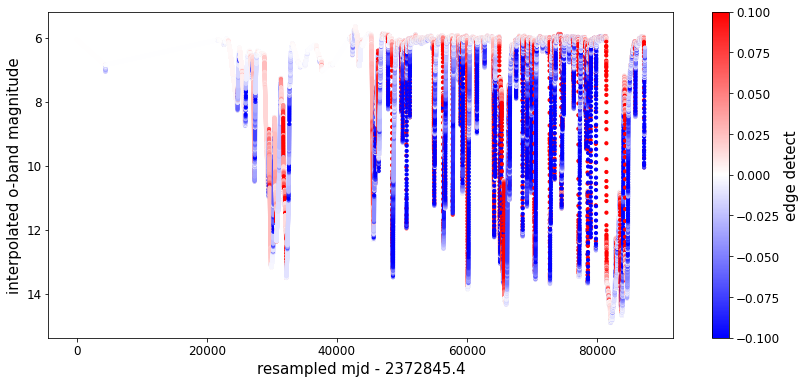

In [42]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,
            c=new_edge_detect,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

# Actually all the GP stuff should go here :)

In [43]:
# kernel = Matern(length_scale=3, nu=3/2) + WhiteKernel(noise_level=1) #+ ConstantKernel()
# # kernel = Matern(length_scale=3, nu=3/2,length_scale_bounds=(150,1e5)) + WhiteKernel(noise_level=1) #+ ConstantKernel()
# # kernel = RBF(length_scale=1,length_scale_bounds=(1e-05, 10)) + WhiteKernel(noise_level=1) #+ ConstantKernel()

In [44]:
# # median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m']

# time = np.asarray(savgol_filtered_oband['mjd']-mjd_scale)
# time = time.reshape(-1,1)

# # the gp assumes the mean value is zero
# mean_val = np.min(savgol_filtered_oband['m'])
# norm_val = np.max(savgol_filtered_oband['m']-mean_val)


# # mean_val = np.min(iter_savgol_filtered)
# # norm_val = np.max(iter_savgol_filtered-mean_val)

In [45]:
# gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
# gp.fit(time, (savgol_filtered_oband['m']-mean_val)/norm_val)
# # gp.fit(time, (iter_savgol_filtered-mean_val)/norm_val)


# # gp.fit(time, savgol_filtered_oband['m'])
# # GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
# #                 kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
# #                 n_restarts_optimizer=0, normalize_y=False,
# #                 optimizer='fmin_l_bfgs_b', random_state=None)

In [46]:
# gp.kernel_

### big question: what resolution should I resample to?

Probably once a night is fine, RCBs shouldn't vary much more than that??

In [47]:
# x_pred = np.linspace(0, int(np.max(time))+1, int(np.max(time))+1).reshape(-1,1)
# y_pred, sigma = gp.predict(x_pred, return_std=True)

In [48]:
# plt.figure(figsize=(14,6))

# plt.plot(x_pred,(y_pred*norm_val)+mean_val)
# plt.errorbar(x_pred, (y_pred*norm_val)+mean_val, yerr=sigma*norm_val, capsize=0, color='tab:red',alpha=0.2)
# # plt.plot(x_pred,y_pred)
# # plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,alpha=0.5,color='tab:orange')
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,iter_savgol_filtered,s=10,color='tab:blue',alpha=0.75)

# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('savgol filtered o-band magnitude')
# # plt.xlim(1000,3000)
# plt.show()

In [49]:
# gpsmoothed_time = time
# gpsmoothed_flux, gpsigma = gp.predict(gpsmoothed_time, return_std=True)
# gpsmoothed_flux = (gpsmoothed_flux*norm_val)+mean_val
# gpsigma = gpsigma*norm_val

In [50]:
# plt.figure(figsize=(14,6))

# # plt.plot(x_pred,y_pred)
# # plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

# plt.plot(x_pred,(y_pred*norm_val)+mean_val)
# plt.errorbar(x_pred, (y_pred*norm_val)+mean_val, yerr=sigma*norm_val, capsize=0, color='tab:red',alpha=0.2)

# plt.scatter(gpsmoothed_time,gpsmoothed_flux,color='tab:green',zorder=3)

# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('savgol filtered o-band magnitude')
# # plt.xlim(1000,3000)
# plt.show()

In [51]:
# gp_edge_detect = sp.ndimage.convolve((y_pred*norm_val)+mean_val, [1.0, 0.0, -1.0])

In [52]:
# # np.std()

# plt.figure(figsize=(14,6))
# plt.scatter(x_pred,gp_edge_detect,s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(oband['mjd'][0]))
# plt.ylabel('edge detection')
# plt.ylim(-0.1,0.1)
# plt.show()

In [53]:
# plt.figure(figsize=(14,6))
# # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
# plt.scatter(x_pred,(y_pred*norm_val)+mean_val,s=10,
#             c=gp_edge_detect,cmap='bwr')#,alpha=0.2)
# # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
# plt.ylabel('interpolated o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-0.1,0.1)
# # lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# # plt.clim(-lim,lim)
# # plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
# plt.show()

In [54]:
# ### remove this if you don't want to use the gp-filtered data
# resample_time = x_pred
# resample_flux = (y_pred*norm_val)+mean_val #y_pred
# new_edge_detect = gp_edge_detect

In [55]:
# ## interpolate the edge detection to convert back to the original times
# # np.linspace(0, int(np.max(time)), int(np.max(time)))
# gp_edgedetect_interp = sp.interpolate.interp1d(x_pred[:,0],
#                                                  gp_edge_detect,
#                                                  kind='slinear')

# gp_edges = gp_edgedetect_interp(savgol_filtered_oband['mjd']-mjd_scale)

In [56]:
# plt.figure(figsize=(14,6))
# # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
# plt.scatter(gpsmoothed_time,gpsmoothed_flux,s=10,
#             c=gp_edges,cmap='bwr')#,alpha=0.2)
# # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
# plt.gca().invert_yaxis()
# plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
# plt.ylabel('interpolated o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-0.1,0.1)
# # lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# # plt.clim(-lim,lim)
# # plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
# plt.show()

In [57]:
# plt.figure(figsize=(14,6))

# plt.scatter(gpsmoothed_time,(savgol_filtered_oband['m']-gpsmoothed_flux)+np.min(savgol_filtered_oband['m']),
#             s=10)#,c=gp_edges,cmap='bwr')
# plt.scatter(gpsmoothed_time,savgol_filtered_oband['m'],s=10,
#             c=savgol_filtered_oband['m']-gpsmoothed_flux,cmap='cividis')#,alpha=0.2)

# plt.gca().invert_yaxis()
# plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
# plt.ylabel('interpolated o-band magnitude')
# plt.colorbar(label='diff to gp model')
# plt.clim(-0.25,0.25)
# plt.show()

# Now back to normal

In [58]:
## interpolate the edge detection to convert back to the original times
# edge_detect_interp_func = sp.interpolate.interp1d(resample_time,
#                                                  new_edge_detect,
#                                                  kind='slinear')

# edges_realdata = edge_detect_interp_func(median_filtered_oband['mjd']-mjd_scale)


In [59]:
# plt.figure(figsize=(14,6))
# plt.scatter(median_filtered_oband['mjd']-mjd_scale,edges_realdata,s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('edge detect back to real data')
# # plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# # plt.clim(-1,1)
# plt.show()

In [60]:
# plt.figure(figsize=(14,6))
# # plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(edges_realdata+3)*4,s=10)
# plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,
#             c=(edges_realdata),cmap='bwr')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('median filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-0.1,0.1)
# # plt.xlim(950,1200)
# # plt.xlim(500,1000)
# # plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
# plt.show()

In [61]:
# ### toggle this cell for switching between slinear interpolation and GP interpolation ######

# resample_time = x_pred
# resample_time = resample_time.reshape(len(resample_time))
# resample_flux = (y_pred*norm_val)+mean_val #y_pred
# new_edge_detect = gp_edge_detect

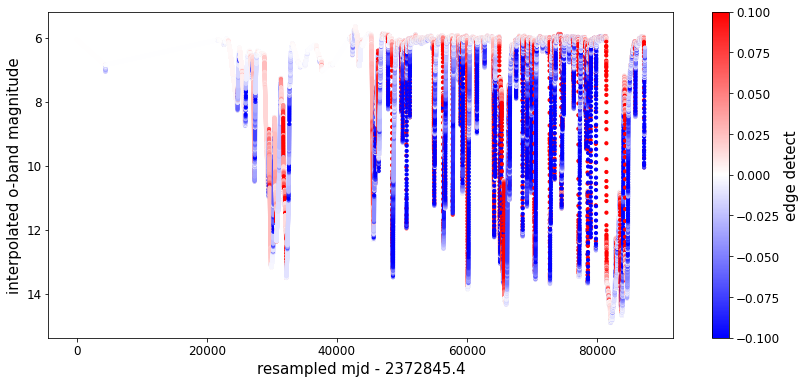

In [62]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,
            c=new_edge_detect,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

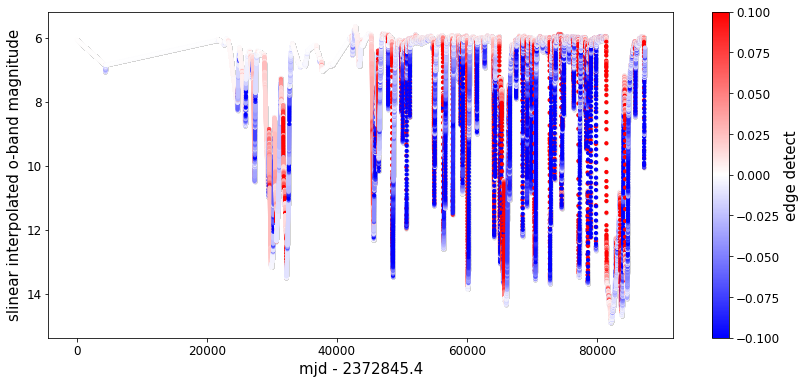

In [63]:
# std_dev = np.std(new_edge_detect)
# # std_dev
# new_mask = np.where(np.abs(new_edge_detect)>(std_dev*0.25),True,False)
new_mask = np.where(np.abs(new_edge_detect)>0,True,False)

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
plt.scatter(resample_time[new_mask],resample_flux[new_mask],s=10,
            c=new_edge_detect[new_mask],cmap='bwr')
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(savgol_filtered_oband['mjd'][new_mask]-mjd_scale,savgol_filtered_oband['m'][new_mask],s=10,
#             c=(gp_edges[new_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

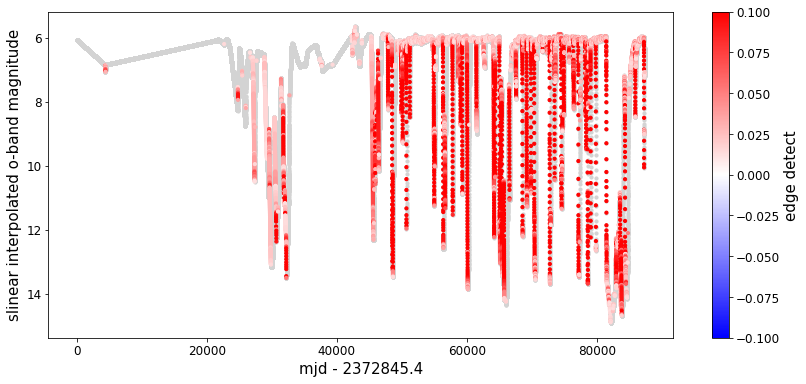

In [64]:
std_dev = np.std(new_edge_detect)
new_mask = np.where(np.abs(new_edge_detect)>(std_dev*0.25),True,False)
downslope_mask = np.where(new_edge_detect>0.0,True,False)
total_mask = new_mask & downslope_mask

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
            c=new_edge_detect[total_mask],cmap='bwr')
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(savgol_filtered_oband['mjd'][total_mask]-mjd_scale,savgol_filtered_oband['m'][total_mask],s=10,
#             c=(gp_edges[total_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

In [65]:
## this doesn't work with gp filtered data
gradient = np.gradient(resample_flux, resample_time)

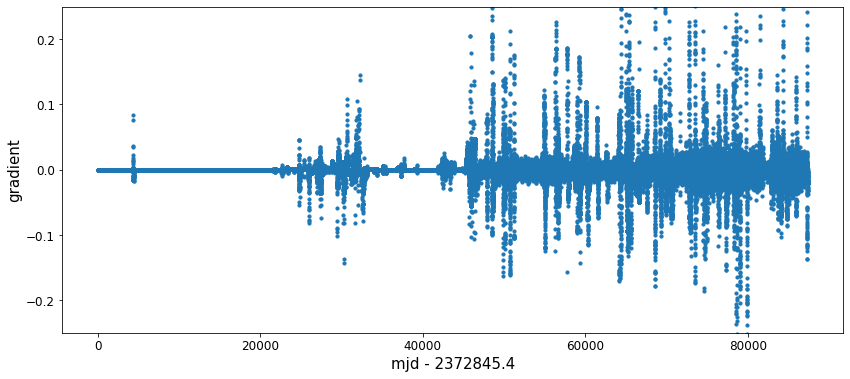

In [66]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,gradient,s=10)
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('gradient')
plt.ylim(-0.25,0.25)
plt.show()

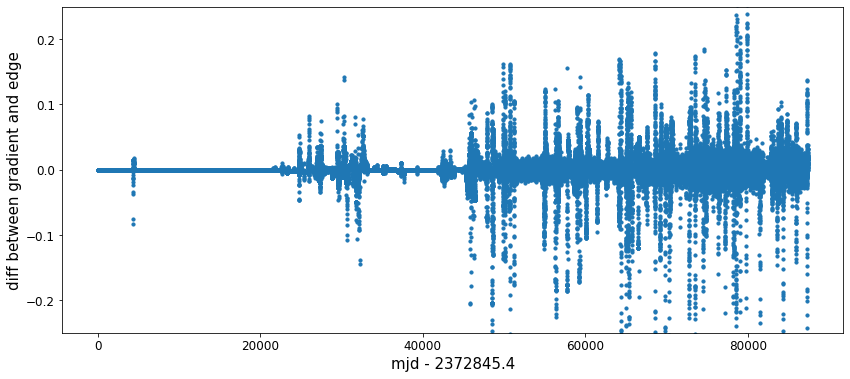

In [67]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,gradient-new_edge_detect,s=10)
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('diff between gradient and edge')
plt.ylim(-0.25,0.25)
plt.show()

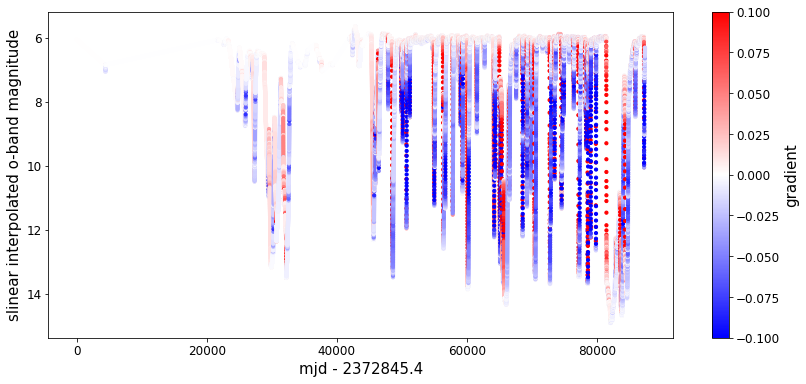

In [68]:
plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
# plt.scatter(resample_time,gradient,s=10,color='lightgrey')
plt.scatter(resample_time,resample_flux,s=10,
            c=gradient,cmap='bwr')
# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(savgol_filtered_oband['mjd'][total_mask]-mjd_scale,savgol_filtered_oband['m'][total_mask],s=10,
#             c=(gp_edges[total_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='gradient')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

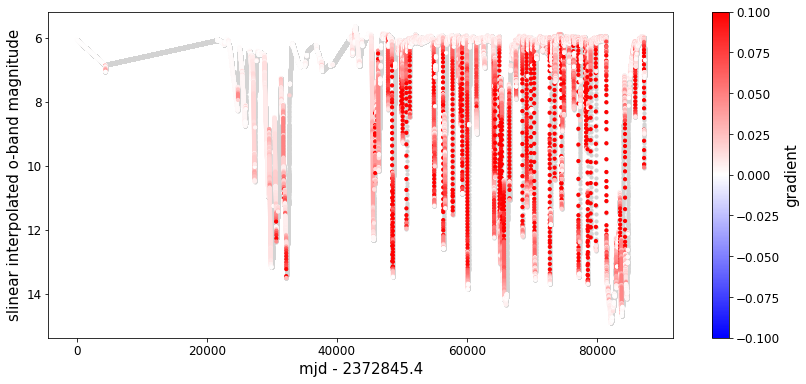

In [69]:
downslope_mask = np.where(gradient>0,True,False)
total_mask = downslope_mask

plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
plt.scatter(resample_time[downslope_mask],resample_flux[downslope_mask],s=10,
            c=gradient[downslope_mask],cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='gradient')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

In [70]:
def find_runs(x):
    x = np.asanyarray(x)
    n = x.shape[0]
    
    # find run starts
    loc_run_start = np.empty(n, dtype=bool)
    loc_run_start[0] = True
    np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
    run_starts = np.nonzero(loc_run_start)[0]

    # find run values
    run_values = x[loc_run_start]

    # find run lengths
    run_lengths = np.diff(np.append(run_starts, n))

    return run_values, run_starts, run_lengths

In [71]:
run_vals, run_start, run_length = find_runs(total_mask)

In [72]:
downward_mask = run_start[np.logical_and(run_vals==True,run_length > 3)]
upward_mask = run_start[np.logical_and(run_vals==False,run_length > 3)]

In [73]:
# resample_time[downward_mask]

In [74]:
# resample_time[run_start]

In [75]:
# resample_flux[run_start]

In [76]:
decline_min_depth = 0.9
decline_onset = []
decline_end = []
decline_depth = []
for i in range(0,len(resample_flux[run_start])):
    if i == 0 and np.abs(resample_flux[0] - resample_flux[run_start[i+1]]) > decline_min_depth:
        ## adding the absolute magnitude should detect beginning declines
        ## NEEDS TO BE TESTED
        decline_onset.append(0)
        print('beginning')
        print('0')
        print(resample_flux[0])
        print(np.abs(resample_flux[0] - resample_flux[run_start[i]]))
        decline_end.append(run_start[i+1])
        decline_depth.append(np.abs(resample_flux[0] - resample_flux[run_start[i+1]]))
    elif i == len(resample_flux[run_start])-1:
        if resample_flux[-1] - resample_flux[run_start[i]] > decline_min_depth:
            decline_onset.append(run_start[i])
            print('end')
            print(run_start[i])
            print(resample_flux[run_start[i]])
            print(resample_flux[-1] - resample_flux[run_start[i]])
            decline_end.append(len(resample_flux)-1)
            decline_depth.append(resample_flux[-1] - resample_flux[run_start[i]])
    elif resample_flux[run_start[i+1]] - resample_flux[run_start[i]] > decline_min_depth:#1:
        decline_onset.append(run_start[i])
        print(run_start[i])
        print(resample_flux[run_start[i]])
        print(resample_flux[run_start[i+1]] - resample_flux[run_start[i]])
        decline_end.append(run_start[i+1])
        decline_depth.append(resample_flux[run_start[i+1]] - resample_flux[run_start[i]])
#     if i == len(resample_flux[run_start]):
#         print('end')
print(resample_flux[decline_end])
print(decline_depth)

beginning
0
6.068541823599332
0.0
23459
6.273562225490459
1.0229619974897837
24102
7.284290146676938
0.9902548273790739
25400
7.01927533671297
1.7387035908442003
27057
6.565676958643552
3.879476936645487
28861
6.734647445443245
2.569584276657861
29262
9.778630462159482
1.187321731385616
29587
9.308625193668439
3.7934207907822852
30388
8.478960899215895
2.2411622437542658
30568
10.62576030996205
1.7342495563788667
31394
7.258576306828118
1.4103766006227154
31750
8.458431606487297
1.2745452997141946
31780
9.743532816389884
1.477594124722044
32006
10.751276708694212
0.9081984821565978
32193
12.14398164861229
1.3549518658905555
45306
6.191989171873616
6.123806987854429
45873
8.285125624799312
1.3525167401921703
46040
7.359390277167587
1.0675005430745257
46336
6.4047358761314
0.9331063030734228
46361
7.102204744523173
2.345045203787092
47851
6.232774266942518
2.017659862864842
48462
6.104867707094636
7.11409570846976
48590
10.21428811062419
3.2650738558704386
49867
6.111846056304395
2.21594

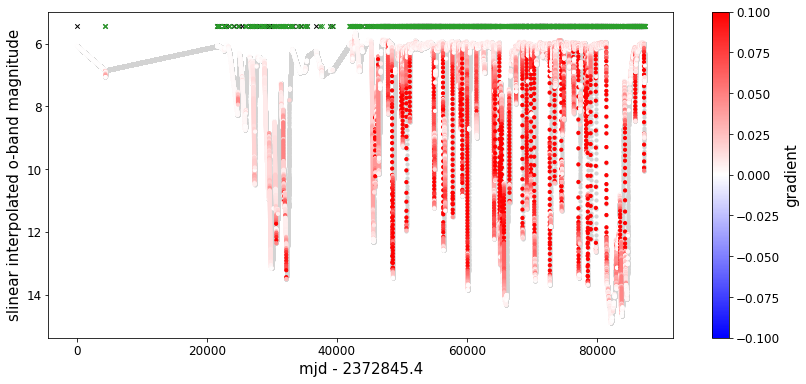

In [77]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
plt.scatter(resample_time[downward_mask],
            np.full(len(resample_time[downward_mask]),np.min(resample_flux))-0.2,
            s=20,marker='x',color='k',zorder=3)
plt.scatter(resample_time[upward_mask],
            np.full(len(resample_time[upward_mask]),np.min(resample_flux))-0.2,
                    s=20,marker='x',color='tab:green',zorder=3)
# plt.scatter(savgol_filtered_oband['mjd'][decline_onset]-mjd_scale,
#             np.full(len(savgol_filtered_oband['mjd'][decline_onset]),np.min(savgol_filtered_oband['m']))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
            c=(gradient[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='gradient')
plt.clim(-0.1,0.1)
plt.show()

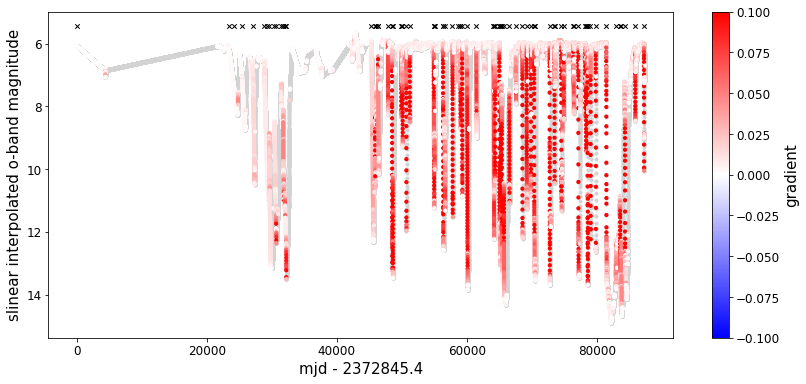

In [78]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
# plt.scatter(resample_time[downward_mask]-mjd_scale,
#             np.full(len(resample_time[downward_mask]),np.min(resample_flux))-0.2
#                     ,s=20,marker='x',color='k',zorder=3)
# plt.scatter(resample_time[upward_mask]-mjd_scale,
#             np.full(len(resample_time[upward_mask]),np.min(resample_flux))-0.2
#                     ,s=20,marker='x',color='tab:green',zorder=3)
plt.scatter(resample_time[decline_onset],
            np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
                    s=20,marker='x',color='k',zorder=3)
plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
            c=(gradient[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('slinear interpolated o-band magnitude')
plt.colorbar(label='gradient')
plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
plt.show()

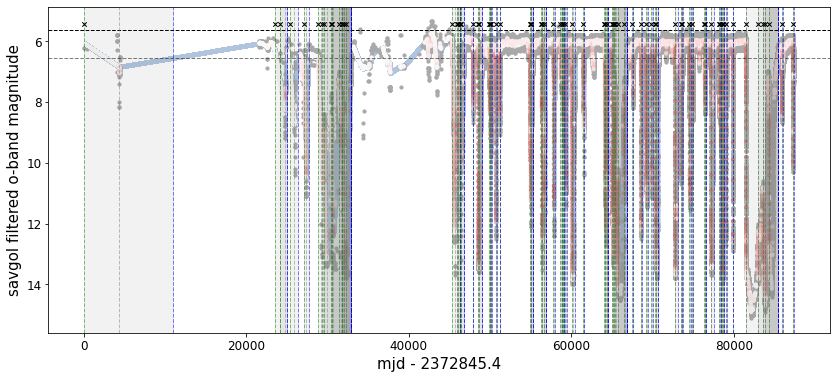

In [79]:
plt.figure(figsize=(14,6))

plt.scatter(resample_time,resample_flux,s=10,color='lightsteelblue')

plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],
            s=10,color='darkgrey')

# plt.scatter(resample_time[decline_onset],
#             np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
            c=(gradient[total_mask]),cmap='bwr',alpha=0.2)
plt.clim(-0.1,0.1)


onset_arr = []
onset_flag = []
max_depth_arr = []
end_arr = []
end_flag = []

max_light = np.min(resample_flux)
plt.axhline(max_light,color='k',linestyle='--')
plt.axhline(max_light+decline_min_depth,color='k',linestyle='--',alpha=0.5)
for i in range(0,len(resample_time[decline_onset])):
    flag_set = False
    if decline_onset[i] == 0:
#         print('beginning of array')
        onset_flag.append(1)
        flag_set = True
    onset_time = resample_time[decline_onset][i]
    diff_arr = np.abs((savgol_filtered_oband['mjd'][saturation_mask]-mjd_scale)-onset_time)
    if np.min(diff_arr) > 5:
        if decline_depth[i] > decline_min_depth:#12-np.min(savgol_filtered_oband['m']):
            plt.axvline(onset_time,color='red',linestyle='--')
            plt.axvline(resample_time[decline_end[i]],color='grey',linestyle='--',alpha=0.5)
#             plt.axhline(max_light+decline_min_depth+decline_depth[i],color='k',linestyle='--')
            onset_arr.append(onset_time)
            max_depth_arr.append(resample_time[decline_end[i]])
            if flag_set == False:
                onset_flag.append(2)
#             print('onset', onset_time)
        else:
#             print('bad onset')
            onset_flag.append(3)
            onset_arr.append(onset_time)
            max_depth_arr.append(resample_time[decline_end[i]])
            pass
#             plt.axvline(onset_time,color='red',linestyle='--')
    else:
        plt.axvline(onset_time,color='green',linestyle='--',alpha=0.5)
        plt.axvline(resample_time[decline_end[i]],color='grey',linestyle='--',alpha=0.5)
#         plt.axhline(max_light+decline_min_depth+decline_depth[i],linestyle='--')
        if flag_set == False:
            onset_flag.append(0)
        onset_arr.append(onset_time)
        max_depth_arr.append(resample_time[decline_end[i]])
#         print('onset', onset_time)
        
    post_decline_time = resample_time[resample_time>onset_time]
    post_decline_flux = resample_flux[resample_time>onset_time]
    xx = 0
    while post_decline_flux[xx] < (max_light+decline_min_depth):
        xx=xx+1
    else:
#         print('exited max light')
        exit_time = post_decline_time[xx]
        post_decline_time = resample_time[resample_time>exit_time]
        post_decline_flux = resample_flux[resample_time>exit_time]
    
    xx = 0
    try:
        while post_decline_flux[xx] > (max_light+decline_min_depth):
            xx=xx+1
        else:
#             print('reached max light')
#             print(xx,post_decline_flux[xx],post_decline_time[xx])
            plt.axvline(post_decline_time[xx],color='blue',linestyle='--',alpha=0.5)
            end_arr.append(post_decline_time[xx])
            end_flag.append(0)
    except IndexError:
#         print('reached end of array')
#         print(xx-1,post_decline_flux[xx-1],post_decline_time[xx-1])
        plt.axvline(post_decline_time[xx-1],color='blue',linestyle='--',alpha=0.5)
        end_arr.append(post_decline_time[xx-1])
        end_flag.append(1)

        
# print(onset_arr)
# print(onset_flag)
# print(end_arr)
# print(end_flag)
# print(max_depth_arr)

plt.scatter(resample_time[decline_onset][np.asarray(onset_flag) != 3],
            np.full(len(resample_time[decline_onset][np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.2,
                    s=20,marker='x',color='k',zorder=3)

# plt.scatter(resample_time[decline_onset],
#             np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)

for i in range(0,len(onset_arr)):
    if onset_flag[i] != 3:
        plt.axvspan(onset_arr[i], end_arr[i], alpha=0.1, color='grey')



plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
# plt.xlim(60000,80000)
plt.show()

In [80]:
def return_arr_to_orig(time_array):
    return_arr = []
    orig_time = savgol_filtered_oband['mjd']-mjd_scale
    for datapt in time_array:
        matched_time_ind = np.argmin(np.abs(orig_time-datapt))
        return_arr.append(orig_time[matched_time_ind])
    return_arr = np.asarray(return_arr)
    return return_arr

In [81]:
## resample the times back to the original data set
orig_time = savgol_filtered_oband['mjd']-mjd_scale
onset_arr_orig = return_arr_to_orig(onset_arr)
end_arr_orig = return_arr_to_orig(end_arr)
depth_time_orig = return_arr_to_orig(max_depth_arr)

In [82]:
def err_calculation(time_arr):
    orig_time = savgol_filtered_oband['mjd']-mjd_scale
#     print(len(orig_time))
    err_arr = []
    for time in time_arr:
        matched_time_ind = np.argmin(np.abs(orig_time-time))
#         print(matched_time_ind)
        if matched_time_ind != 0 and matched_time_ind > 5 and matched_time_ind < (len(orig_time)-6):
            print((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
            err_arr.append((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
        elif matched_time_ind > (len(orig_time)-6):
            print('end of arr')
            err_arr.append(0)
        else:
            print('beginning of arr')
            err_arr.append(0)
    err_arr = np.asarray(err_arr)
    return err_arr

In [83]:
onset_err_arr = err_calculation(onset_arr_orig)
end_err_arr = err_calculation(end_arr_orig)
depth_err_arr = err_calculation(depth_time_orig)

beginning of arr
385.5
632.5
206.0
47.5
37.0
159.24699999997392
15.712000000057742
95.61000000010245
28.425000000046566
9.024999999906868
17.989999999990687
33.984999999869615
109.0449999999255
37.949999999953434
45.5855000000447
52.730999999912456
29.986000000033528
13.09250000002794
29.962000000057742
8.452999999979511
3.6000000000931323
5.399999999906868
10.514999999897555
2.8850000000093132
4.879999999888241
2.6500000001396984
2.329999999841675
1.4000000001396984
6.445000000065193
3.4399999999441206
1.5300000000279397
1.7949999999254942
1.6999999999534339
3.9699999999720603
6.449999999953434
2.090000000083819
13.135000000009313
2.5
2.3500000000931323
2.0
3.1000000000931323
4.099999999860302
1.6419999999925494
2.699999999953434
2.8999999999068677
15.399999999906868
2.6000000000931323
3.5
4.415000000037253
1.4499999999534339
2.0499999998137355
2.7749999999068677
0.625
1.8500000000931323
1.9714999999850988
0.9550000000745058
0.5
1.2600000000093132
0.633000000147149
0.42850000015459955

In [84]:
## time error calculations based on how many data points are around
err_arr = []
for onset in onset_arr_orig:
    matched_time_ind = np.argmin(np.abs(orig_time-onset))
    if matched_time_ind != 0 and matched_time_ind > 5:
        print((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
        err_arr.append((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
    else:
        print('beginning of arr')
        err_arr.append(0)
err_arr = np.asarray(err_arr)
#     print(orig_time[matched_time_ind-5:matched_time_ind+5])

beginning of arr
385.5
632.5
206.0
47.5
37.0
159.24699999997392
15.712000000057742
95.61000000010245
28.425000000046566
9.024999999906868
17.989999999990687
33.984999999869615
109.0449999999255
37.949999999953434
45.5855000000447
52.730999999912456
29.986000000033528
13.09250000002794
29.962000000057742
8.452999999979511
3.6000000000931323
5.399999999906868
10.514999999897555
2.8850000000093132
4.879999999888241
2.6500000001396984
2.329999999841675
1.4000000001396984
6.445000000065193
3.4399999999441206
1.5300000000279397
1.7949999999254942
1.6999999999534339
3.9699999999720603
6.449999999953434
2.090000000083819
13.135000000009313
2.5
2.3500000000931323
2.0
3.1000000000931323
4.099999999860302
1.6419999999925494
2.699999999953434
2.8999999999068677
15.399999999906868
2.6000000000931323
3.5
4.415000000037253
1.4499999999534339
2.0499999998137355
2.7749999999068677
0.625
1.8500000000931323
1.9714999999850988
0.9550000000745058
0.5
1.2600000000093132
0.633000000147149
0.42850000015459955

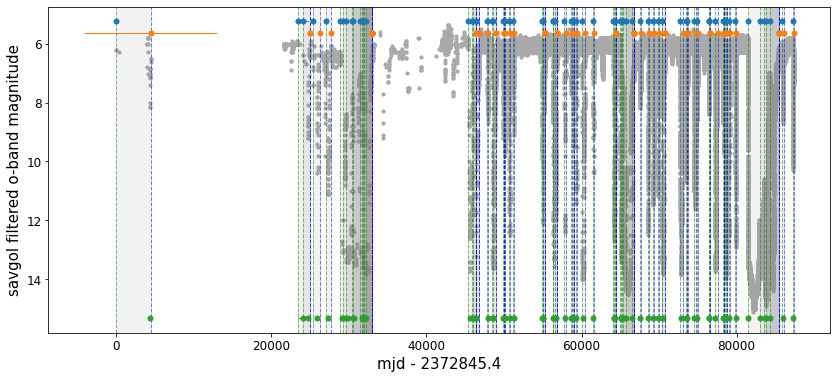

In [85]:
plt.figure(figsize=(14,6))

# plt.scatter(resample_time,resample_flux,s=10,color='lightsteelblue')

plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],
            s=10,color='darkgrey')

# plt.scatter(resample_time[decline_onset],
#             np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
# plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
#             c=(gradient[total_mask]),cmap='bwr',alpha=0.2)
# plt.clim(-0.1,0.1)

# plt.scatter(onset_arr_orig[np.asarray(onset_flag) != 3],
#             np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.4,
#                     s=20,marker='x',color='k',zorder=3)

plt.errorbar(x=onset_arr_orig[np.asarray(onset_flag) != 3],
            y=np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.4,
             xerr=onset_err_arr[np.asarray(onset_flag) != 3],fmt='o')


# plt.scatter(end_arr_orig[np.asarray(onset_flag) != 3],
#             np.full(len(end_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0,
#                     s=20,marker='x',color='k',zorder=3)

plt.errorbar(x=end_arr_orig[np.asarray(onset_flag) != 3],
            y=np.full(len(end_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0,
             xerr=end_err_arr[np.asarray(onset_flag) != 3],fmt='o')

# plt.scatter(onset_arr_orig[np.asarray(onset_flag) != 3],
#             np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.4,
#                     s=20,marker='x',color='k',zorder=3)

plt.errorbar(x=depth_time_orig[np.asarray(onset_flag) != 3],
            y=np.full(len(depth_time_orig[np.asarray(onset_flag) != 3]),np.max(resample_flux))+0.4,
             xerr=depth_err_arr[np.asarray(onset_flag) != 3],fmt='o')


for onset_time in onset_arr_orig[np.asarray(onset_flag) != 3]:
    plt.axvline(onset_time,color='green',alpha=0.5,linestyle='--')
    
for end_time in end_arr_orig[np.asarray(onset_flag) != 3]:
    plt.axvline(end_time,color='blue',alpha=0.5,linestyle='--')
    
for i in range(0,len(onset_arr_orig)):
    if onset_flag[i] != 3:
        plt.axvspan(onset_arr_orig[i], end_arr_orig[i], alpha=0.1, color='grey')


# plt.scatter(resample_time[decline_onset][np.asarray(onset_flag) != 3],
#             np.full(len(resample_time[decline_onset][np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)

# for i in range(0,len(onset_arr)):
#     if onset_flag[i] != 3:
#         plt.axvspan(onset_arr[i], end_arr[i], alpha=0.1, color='grey')



plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('savgol filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight',dpi=300)
plt.show()

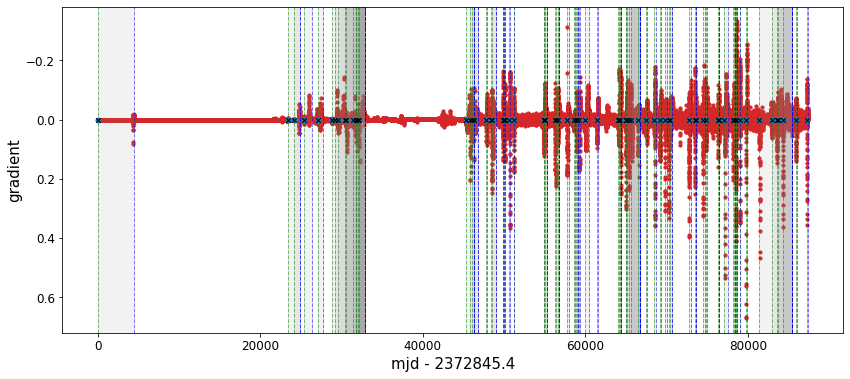

In [86]:
plt.figure(figsize=(14,6))

# plt.scatter(resample_time,resample_flux,s=10,color='lightsteelblue')

plt.scatter(resample_time,gradient,s=10,color='tab:red')


# plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],
#             s=10,color='darkgrey')

# plt.scatter(resample_time[decline_onset],
#             np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
# plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
#             c=(gradient[total_mask]),cmap='bwr',alpha=0.2)
# plt.clim(-0.1,0.1)

plt.scatter(onset_arr_orig[np.asarray(onset_flag) != 3],
            np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),0),
                    s=20,marker='x',color='k',zorder=3)

plt.errorbar(x=onset_arr_orig[np.asarray(onset_flag) != 3],
            y=np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),0),
             xerr=err_arr[np.asarray(onset_flag) != 3],fmt='o')

for onset_time in onset_arr_orig[np.asarray(onset_flag) != 3]:
    plt.axvline(onset_time,color='green',alpha=0.5,linestyle='--')
    
for end_time in end_arr_orig[np.asarray(onset_flag) != 3]:
    plt.axvline(end_time,color='blue',alpha=0.5,linestyle='--')
    
for i in range(0,len(onset_arr_orig)):
    if onset_flag[i] != 3:
        plt.axvspan(onset_arr_orig[i], end_arr_orig[i], alpha=0.1, color='grey')


# plt.scatter(resample_time[decline_onset][np.asarray(onset_flag) != 3],
#             np.full(len(resample_time[decline_onset][np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.2,
#                     s=20,marker='x',color='k',zorder=3)

# for i in range(0,len(onset_arr)):
#     if onset_flag[i] != 3:
#         plt.axvspan(onset_arr[i], end_arr[i], alpha=0.1, color='grey')



plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('gradient')
# plt.colorbar(label='edge detect')
# plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
plt.show()

In [87]:
## these times are in the resampled array, which has no gaps, compared to the real data
## We'll need to transform back to the original array and use the the distance to a datapoint as an error

decline_arr = np.array([onset_arr_orig,onset_err_arr,onset_flag,
                        end_arr_orig,end_err_arr,end_flag,
                        depth_time_orig,depth_err_arr,
                        decline_depth,resample_flux[decline_end]])
decline_frame = pd.DataFrame(decline_arr.T,
                             columns=['onset_time','onset_err','onset_flag','end_time','end_err',
                                      'end_flag','depth_time','depth_err','decline_depth','min_mag'])
decline_frame

,onset_time,onset_err,onset_flag,end_time,end_err,end_flag,depth_time,depth_err,decline_depth,min_mag
0,0.00000,0.000000,1.0,4430.000,8590.300000,0.0,4366.0000,41.500000,0.963566,7.032108
1,23458.60000,385.500000,0.0,24948.600,68.500000,0.0,24097.6000,633.500000,1.022962,7.296524
2,24101.60000,632.500000,0.0,24948.600,68.500000,0.0,24721.6000,326.000000,0.990255,8.274545
3,25399.60000,206.000000,0.0,26335.600,95.000000,0.0,25893.6000,153.000000,1.738704,8.757979
4,27056.60000,47.500000,0.0,27687.600,59.500000,0.0,27331.6000,8.500000,3.879477,10.445154
...,...,...,...,...,...,...,...,...,...,...
72,83568.94722,0.485750,0.0,85419.025,1.205800,0.0,83610.9600,1.156945,2.563434,13.454505
73,83763.88125,13.000000,0.0,85419.025,1.205800,0.0,83810.3400,11.511500,2.035000,14.322088
74,84314.93000,0.497200,0.0,85419.025,1.205800,0.0,84357.6076,1.026015,4.812094,12.856086
75,85895.85000,0.503450,0.0,86046.299,3.615695,0.0,85925.8400,0.963500,2.215313,8.464920


In [88]:
decline_frame[decline_frame['onset_time']>45000]

,onset_time,onset_err,onset_flag,end_time,end_err,end_flag,depth_time,depth_err,decline_depth,min_mag
15,45305.92400,45.585500,0.0,46326.0600,13.082000,0.0,45637.3000,34.482000,6.123807,12.315796
16,45873.35000,52.731000,0.0,46326.0600,13.082000,0.0,45891.3150,8.964500,1.352517,9.637642
17,46041.03300,29.986000,0.0,46326.0600,13.082000,0.0,46095.8990,20.352350,1.067501,8.426891
18,46337.01700,13.092500,0.0,46777.2875,3.985950,0.0,46358.2042,11.513550,0.933106,7.337842
19,46361.30000,29.962000,0.0,46777.2875,3.985950,0.0,46416.0100,31.864500,2.345045,9.447250
...,...,...,...,...,...,...,...,...,...,...
72,83568.94722,0.485750,0.0,85419.0250,1.205800,0.0,83610.9600,1.156945,2.563434,13.454505
73,83763.88125,13.000000,0.0,85419.0250,1.205800,0.0,83810.3400,11.511500,2.035000,14.322088
74,84314.93000,0.497200,0.0,85419.0250,1.205800,0.0,84357.6076,1.026015,4.812094,12.856086
75,85895.85000,0.503450,0.0,86046.2990,3.615695,0.0,85925.8400,0.963500,2.215313,8.464920


In [95]:
# (87000-45000)/365

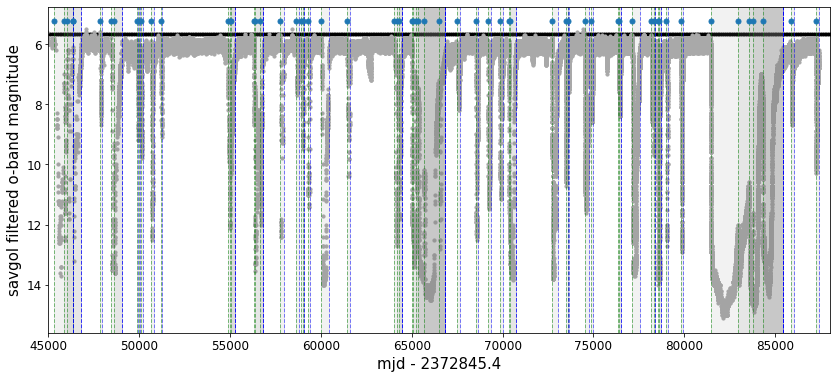

In [89]:
plt.figure(figsize=(14,6))

n = np.arange(-600,600)
def rcrb_ephemeris(n):
    return 2443192.4 + 42.97*n

plt.scatter(rcrb_ephemeris(n)-mjd_scale,
            np.full(len(n),np.min(resample_flux)),
           marker='x',s=10,color='k')

plt.scatter(savgol_filtered_oband['mjd']-mjd_scale,savgol_filtered_oband['m'],
            s=10,color='darkgrey')

plt.errorbar(x=onset_arr_orig[np.asarray(onset_flag) != 3],
            y=np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.4,
             xerr=onset_err_arr[np.asarray(onset_flag) != 3],fmt='o')

for onset_time in onset_arr_orig[np.asarray(onset_flag) != 3]:
    plt.axvline(onset_time,color='green',alpha=0.5,linestyle='--')
    
for end_time in end_arr_orig[np.asarray(onset_flag) != 3]:
    plt.axvline(end_time,color='blue',alpha=0.5,linestyle='--')
    
for i in range(0,len(onset_arr_orig)):
    if onset_flag[i] != 3:
        plt.axvspan(onset_arr_orig[i], end_arr_orig[i], alpha=0.1, color='grey')


plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('savgol filtered o-band magnitude')
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight',dpi=300)
plt.xlim(45000,88000)
# plt.ylim(np.min(resample_flux)+1,np.min(resample_flux)-1)
# plt.xlim(55000,60000)
plt.show()

In [90]:
from astropy.timeseries import LombScargle

In [91]:
def calc_lomb_scargle(t,y):
   oversample = 1
   tmax = t.max()
   tmin = t.min()
   df = 1.0 / (tmax - tmin)
   fmin = df
   fmax = 1 # maximum frequency in cycles per day (c/d)
 
   freq = np.arange(fmin, fmax, df / oversample)
   model = LombScargle(t, y)
   sc = model.power(freq, method="fast", normalization="psd")
 
   fct = np.sqrt(4./len(t))
   amp = np.sqrt(sc) * fct
   return freq, amp*1E6 # return frequency in muHz and amplitude in ppm

In [92]:
# freq, amp = calc_lomb_scargle(savgol_filtered_oband['mjd']-mjd_scale,
#                               savgol_filtered_oband['m'])

freq, amp = calc_lomb_scargle(savgol_filtered_oband['mjd'][savgol_filtered_oband['mjd']-mjd_scale>45000]-mjd_scale,
                              savgol_filtered_oband['m'][savgol_filtered_oband['mjd']-mjd_scale>45000])

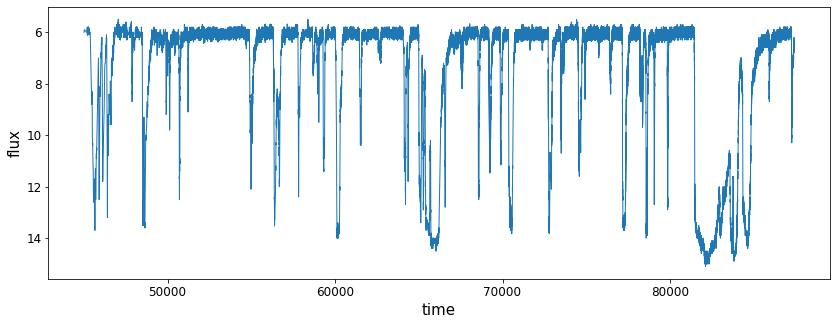

In [96]:
plt.figure(figsize=(14,5))
plt.plot(savgol_filtered_oband['mjd'][savgol_filtered_oband['mjd']-mjd_scale>45000]-mjd_scale,
                              savgol_filtered_oband['m'][savgol_filtered_oband['mjd']-mjd_scale>45000])
# plt.axvline(1/42,color='k',alpha=0.5)
# plt.axvline(3.4e-2,color='k')
plt.xlabel('time')
plt.ylabel('flux')
plt.gca().invert_yaxis()
plt.show()

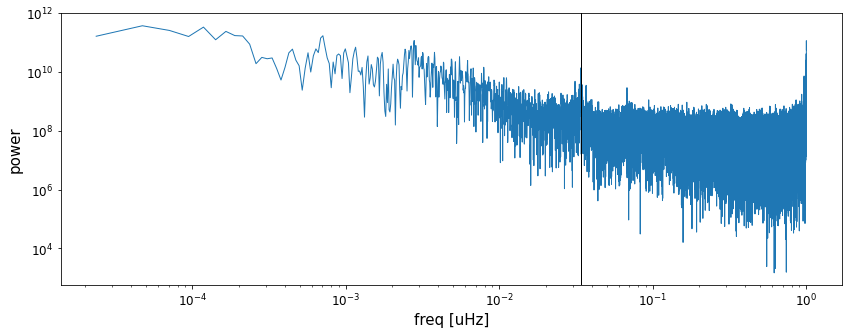

In [97]:
plt.figure(figsize=(14,5))
plt.plot(freq,amp**2)
# plt.axvline(1/42,color='k',alpha=0.5)
plt.axvline(3.4e-2,color='k')
plt.xlabel('freq [uHz]')
plt.ylabel('power')
# plt.xlim(30,50)
# plt.xlim(0,0.1)
# plt.xlim(0,100)
# plt.yticks([])
plt.yscale('log')
plt.xscale('log')
# plt.xlim(0.0,0.2)
# plt.xlim(0.03,0.038)
# plt.ylim(top=0.5e11)
plt.show()

In [98]:
11.574/3.4e-2

340.4117647058823

In [99]:
time = savgol_filtered_oband['mjd'][savgol_filtered_oband['mjd']-mjd_scale>45000]-mjd_scale
is_decline = np.zeros(len(time))
idx = np.isin(time, onset_arr_orig)
is_decline[idx] = 2

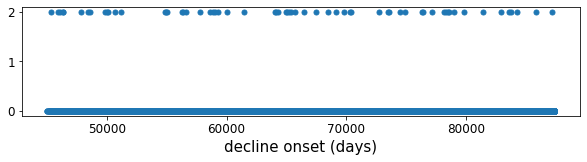

In [100]:
plt.figure(figsize=(10,2))
plt.scatter(time,is_decline)
plt.xlabel('decline onset (days)')
# plt.yticks([])
plt.show()

In [101]:
freq, amp = calc_lomb_scargle(time,is_decline)

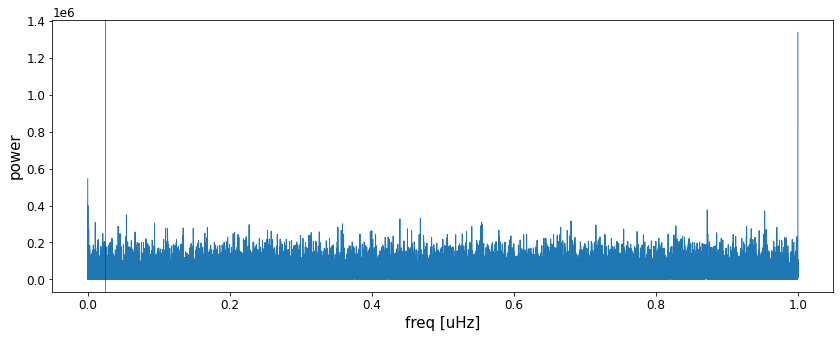

In [102]:
plt.figure(figsize=(14,5))
plt.plot(freq,amp**2)
plt.axvline(1/42,color='k',alpha=0.5)
plt.xlabel('freq [uHz]')
plt.ylabel('power')
plt.show()

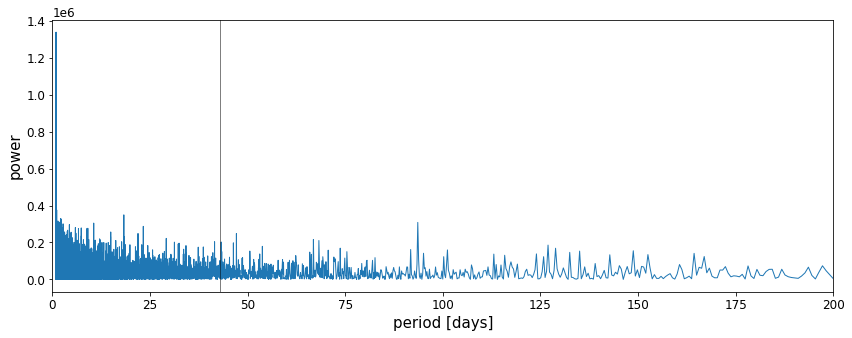

In [103]:
plt.figure(figsize=(14,5))
plt.plot(1/freq,amp**2)
plt.axvline(42.97,color='k',alpha=0.5)
# plt.axvline(18,color='k')
plt.xlabel('period [days]')
plt.ylabel('power')
plt.xlim(0,200)
plt.show()

In [104]:
decline_mask = np.full(len(savgol_filtered_oband['mjd']),
                       True)
time = savgol_filtered_oband['mjd']-mjd_scale
for i in range(0,len(onset_arr_orig)):
    if onset_flag[i] != 3:
        condition = np.logical_and(time > onset_arr_orig[i], time < end_arr_orig[i])
#         print(~condition)
        decline_mask = decline_mask & ~condition

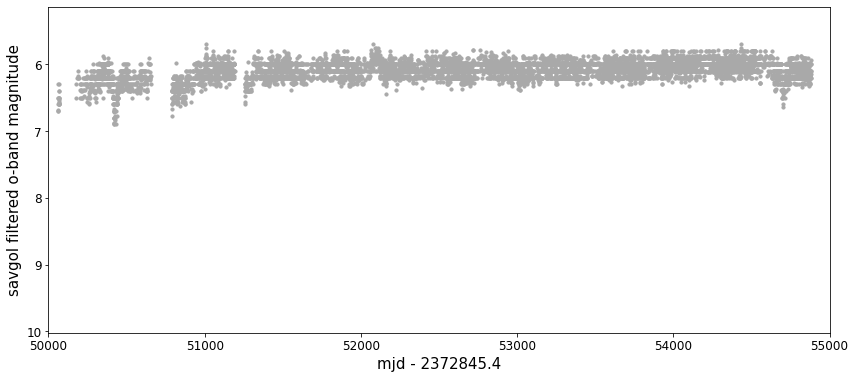

In [116]:
plt.figure(figsize=(14,6))

plt.scatter(savgol_filtered_oband['mjd'][decline_mask]-mjd_scale,savgol_filtered_oband['m'][decline_mask],
            s=10,color='darkgrey')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('savgol filtered o-band magnitude')
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight',dpi=300)
plt.xlim(45000,88000)
plt.xlim(50000,55000)
# plt.ylim(np.min(resample_flux)+1,np.min(resample_flux)-1)
# plt.xlim(55000,60000)
plt.show()

In [109]:
maxlight_time = savgol_filtered_oband['mjd'][decline_mask]-mjd_scale
maxlight_flux = savgol_filtered_oband['m'][decline_mask]

In [110]:
freq, amp = calc_lomb_scargle(maxlight_time[maxlight_time>45000],
                              maxlight_flux[maxlight_time>45000])

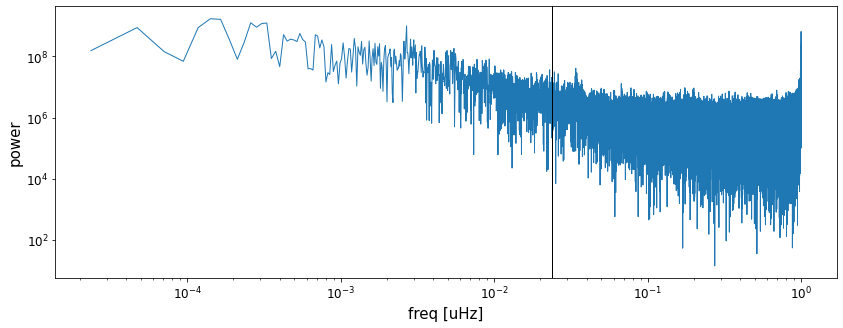

In [111]:
plt.figure(figsize=(14,5))
plt.plot(freq,amp**2)
plt.axvline(1/42,color='k')
# plt.axvline(3.4e-2,color='k')
plt.xlabel('freq [uHz]')
plt.ylabel('power')
plt.yscale('log')
plt.xscale('log')
plt.show()

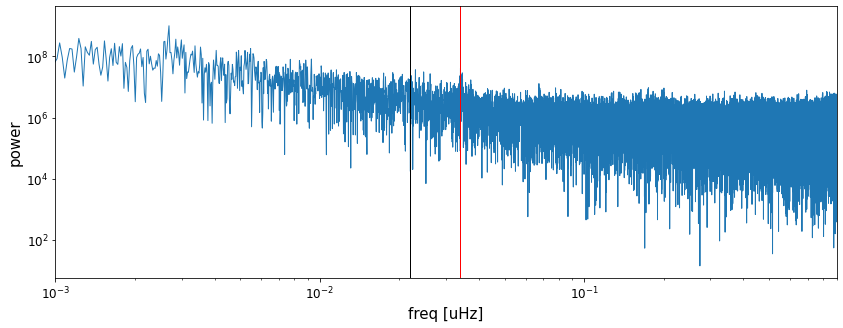

In [112]:
plt.figure(figsize=(14,5))
plt.plot(freq,amp**2)
# plt.axvline(1/42,color='k')
plt.axvline(0.022,color='k')
# plt.axvline(0.023,color='k')
plt.axvline(3.4e-2,color='red')
plt.xlabel('freq [uHz]')
plt.ylabel('power')
plt.yscale('log')
plt.xscale('log')
# plt.xlim(0.015,0.03)
plt.xlim(10**-3,9e-1)
# plt.ylim(-.1e8,0.5e8)
plt.show()

In [113]:
# 1/0.022

In [114]:
# 0.0247-0.023

In [113]:
def yl_echelle(x, y, period, fmin=None, fmax=None, echelletype="single", offset=0.0):
    '''
    Make an echelle plot used in asteroseismology.
    
    Input parameters
    ----
    x: 1d array-like, freq
    y: 1d array-like, power spectrum
    period: float, length of each vertical stack (Dnu in a frequency echelle, DPi in a period echelle)
    fmin: float, minimum frequency to be plotted
    fmax: float, maximum frequency to be plotted
    echelletype: str, `single` or `replicated`
    offset: float, an amount by which the diagram is shifted horizontally
    
    Return
    ----
    z: a 2d numpy.array, folded power spectrum
    extent: a list, edges (left, right, bottom, top) 
    
    Users can create an echelle diagram with the following command:
    ----
    
    import matplotlib.pyplot as plt
    z, ext = echelle(freq, power, Dnu, fmin=numax-4*Dnu, fmax=numax+4*Dnu)
    plt.imshow(z, extent=ext, aspect='auto', interpolation='nearest')
    
    '''
    
    if fmin is None: fmin=0.
    if fmax is None: fmax=np.nanmax(x)

    fmin = fmin - offset
    fmax = fmax - offset
    x = x - offset

    fmin = 0.0 if fmin<0. else fmin - (fmin % period)

    # define plotting elements
    resolution = np.median(np.diff(x))
    # number of vertical stacks
    n_stack = int((fmax-fmin)/period) 
    # number of point per stack
    n_element = int(period/resolution) 

    fstart = fmin - (fmin % period)
    
    z = np.zeros([n_stack, n_element])
    base = np.linspace(0, period, n_element) if echelletype=='single' else np.linspace(0, 2*period, n_element)
    for istack in range(n_stack):
        z[-istack-1,:] = np.interp(fmin+istack*period+base, x, y)
    
    extent = (0, period, fstart, fstart+n_stack*period) if echelletype=='single' else (0, 2*period, fstart, fstart+n_stack*period)
        
    return z, extent

In [114]:
def echelle_wrapper(freq,power,dnu,fmin,fmax,smooth_percent=0.02):
    fig,ax = plt.subplots(figsize=(8,8))
#     fig,ax = plt.subplots(figsize=(6,8))
    freq_res = np.median(np.diff(freq))
    power = convolve(power, Box1DKernel((dnu*smooth_percent)/freq_res))
    z, ext = yl_echelle(freq, power, dnu, fmin=fmin, fmax=fmax, echelletype="replicated")
    z = np.sqrt(z) #sqrt scaling
    ax.imshow(z, extent=ext, aspect='auto', interpolation='nearest', cmap='BuPu')
    ax.axvline(dnu,color='k',linestyle='--',alpha=0.5)
    ax.set_xlabel(r"Frequency mod "+str("{0:.5f}").format(dnu) + " ($\mu$Hz)",size=20)
#     ax.set_ylabel('Frequency ($\mu$Hz)',size=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

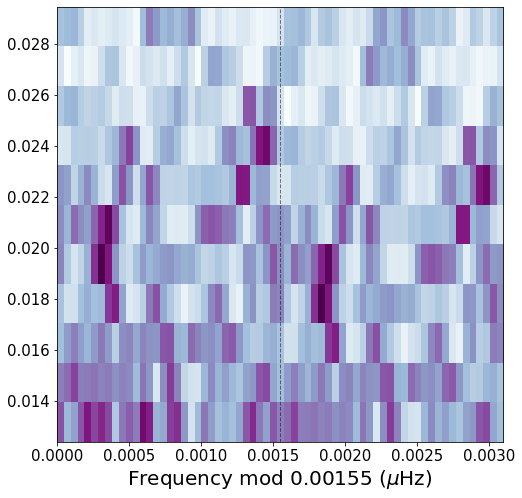

In [115]:
echelle_wrapper(freq,amp**2,0.00155,0.0125,0.03,smooth_percent=0.05)